# Libraries and data

In [40]:
#libraries
import numpy as np
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
from sklearn.model_selection import ParameterGrid

In [3]:
#load the data
#YYYY-MM-DD
df = pd.read_csv('../nyc_data.csv')
future_df = pd.read_csv('../future.csv')
future_df.head()

,Date,Demand,Easter,Thanksgiving,Christmas,Temperature,Marketing
0,1/1/2021,NaN,0,0,0,5.00,154.221
1,1/2/2021,NaN,0,0,0,11.11,264.805
2,1/3/2021,NaN,0,0,0,3.89,115.499
3,1/4/2021,NaN,0,0,0,6.67,124.650
4,1/5/2021,NaN,0,0,0,5.56,77.968


In [4]:
#merge both datasets
df = pd.concat([df, future_df])
df = df.reset_index(drop = True)
df.tail()

,Date,Demand,Easter,Thanksgiving,Christmas,Temperature,Marketing
2218,1/27/2021,NaN,0,0,0,3.33,39.664
2219,1/28/2021,NaN,0,0,0,1.67,195.314
2220,1/29/2021,NaN,0,0,0,-2.78,235.894
2221,1/30/2021,NaN,0,0,0,1.11,152.752
2222,1/31/2021,NaN,0,0,0,4.44,158.620


In [5]:
#Rename variable
df = df.rename(columns = {'Demand': 'y',
                          'Date': 'ds'})
df.head(0)

,ds,y,Easter,Thanksgiving,Christmas,Temperature,Marketing


In [6]:
#Date variable
df.ds = pd.to_datetime(df.ds,
                       format = "%m/%d/%Y")
df.ds

0      2015-01-01
1      2015-01-02
2      2015-01-03
3      2015-01-04
4      2015-01-05
          ...    
2218   2021-01-27
2219   2021-01-28
2220   2021-01-29
2221   2021-01-30
2222   2021-01-31
Name: ds, Length: 2223, dtype: datetime64[ns]

# Holidays

In [7]:
#Easter
dates = pd.to_datetime(df[df.Easter == 1].ds)
easter = pd.DataFrame({'holiday': 'easter',
                       'ds': dates,
                       'lower_window': -5,
                       'upper_window': 2})

In [8]:
#Thanksgiving
dates = pd.to_datetime(df[df.Thanksgiving == 1].ds)
thanksgiving = pd.DataFrame({'holiday': 'thanksgiving',
                             'ds': dates,
                             'lower_window': -3,
                             'upper_window': 6})
thanksgiving

,holiday,ds,lower_window,upper_window
329,thanksgiving,2015-11-26,-3,6
693,thanksgiving,2016-11-24,-3,6
1057,thanksgiving,2017-11-23,-3,6
1421,thanksgiving,2018-11-22,-3,6
1792,thanksgiving,2019-11-28,-3,6
2156,thanksgiving,2020-11-26,-3,6


In [9]:
#Combining events
holidays = pd.concat([easter, thanksgiving])
holidays

,holiday,ds,lower_window,upper_window
94,easter,2015-04-05,-5,2
451,easter,2016-03-27,-5,2
836,easter,2017-04-16,-5,2
1186,easter,2018-04-01,-5,2
1571,easter,2019-04-21,-5,2
1928,easter,2020-04-12,-5,2
329,thanksgiving,2015-11-26,-3,6
693,thanksgiving,2016-11-24,-3,6
1057,thanksgiving,2017-11-23,-3,6
1421,thanksgiving,2018-11-22,-3,6


In [10]:
#removing the holiday columns
df = df.drop(columns = ["Easter", "Thanksgiving"])
df.head(0)

,ds,y,Christmas,Temperature,Marketing


# Facebook Prophet model

In [12]:
#Split the data 
training = df.iloc[:-31,:]
future_df = df.iloc[-31:,:]

In [58]:
#Fetch the parameters
#Estos parámetros salen después de haber tuneado (ver "parameter tuning")
parameters = pd.read_csv("../Forecasting Product/best_params_prophet.csv", 
                         index_col = 0)
parameters

,34
changepoint_prior_scale,0.01
holidays_prior_scale,5
seasonality_mode,additive
seasonality_prior_scale,10
rmse,48.06303866123096


In [14]:
#Extract the values
changepoint_prior_scale = float(parameters.loc["changepoint_prior_scale"].iloc[0])
holidays_prior_scale = float(parameters.loc["holidays_prior_scale"].iloc[0])
seasonality_prior_scale = float(parameters.loc["seasonality_prior_scale"].iloc[0])
seasonality_mode = parameters.loc["seasonality_mode"].iloc[0]

In [15]:
#FB model
m = Prophet(holidays = holidays,
            seasonality_mode = seasonality_mode,
            seasonality_prior_scale = seasonality_prior_scale,
            holidays_prior_scale = holidays_prior_scale,
            changepoint_prior_scale = changepoint_prior_scale)
m.add_regressor('Christmas')
m.add_regressor('Temperature')
m.add_regressor('Marketing')
m.fit(training)

20:06:17 - cmdstanpy - INFO - Chain [1] start processing
20:06:17 - cmdstanpy - INFO - Chain [1] done processing


# Forecasting

In [16]:
#make a future dataframe
future = m.make_future_dataframe(periods = len(future_df),
                                 freq = "D") #W for weekly or M for monthly

future = pd.concat([future, df.iloc[:,2:]], axis = 1)
future.head()

,ds,Christmas,Temperature,Marketing
0,2015-01-01,0,3.68,41.305
1,2015-01-02,0,4.73,131.574
2,2015-01-03,0,7.23,162.700
3,2015-01-04,0,10.96,160.281
4,2015-01-05,0,6.92,51.077


In [17]:
#Forecasting
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas,Christmas_lower,Christmas_upper,Marketing,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01,594.566158,612.738600,761.597704,594.566158,594.566158,0.0,0.0,0.0,-3.364385,...,-4.050387,-4.050387,-4.050387,90.342508,90.342508,90.342508,0.0,0.0,0.0,688.105581
1,2015-01-02,594.682442,531.462868,671.013328,594.682442,594.682442,0.0,0.0,0.0,0.193030,...,-89.459364,-89.459364,-89.459364,88.983244,88.983244,88.983244,0.0,0.0,0.0,604.027838
2,2015-01-03,594.798727,649.528692,785.135956,594.798727,594.798727,0.0,0.0,0.0,1.419676,...,25.265281,25.265281,25.265281,87.789117,87.789117,87.789117,0.0,0.0,0.0,716.560334
3,2015-01-04,594.915011,562.605392,697.575070,594.915011,594.915011,0.0,0.0,0.0,1.324345,...,-55.613893,-55.613893,-55.613893,86.779136,86.779136,86.779136,0.0,0.0,0.0,631.199430
4,2015-01-05,595.031295,691.587812,829.987849,595.031295,595.031295,0.0,0.0,0.0,-2.979280,...,74.332012,74.332012,74.332012,85.966718,85.966718,85.966718,0.0,0.0,0.0,759.928556


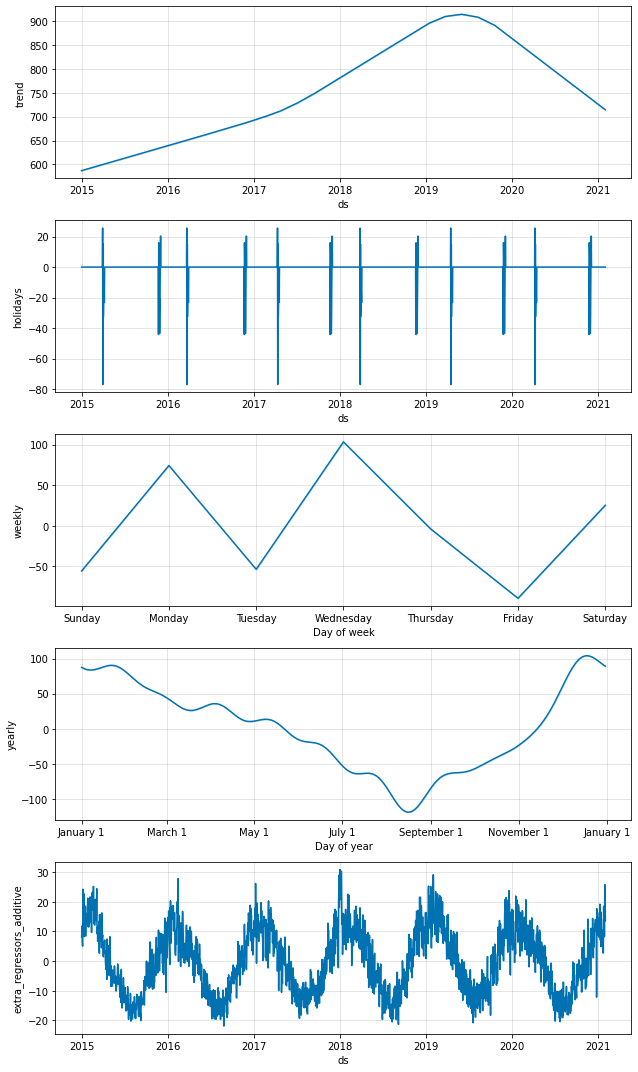

In [ ]:
#Plotting
m.plot_components(forecast);

In [18]:
#extract the predictions
predictions_prophet = forecast.yhat[-len(future_df):].rename("prophet")
predictions_prophet.index = future_df["ds"]
predictions_prophet

ds
2021-01-01    723.554897
2021-01-02    835.213356
2021-01-03    753.683264
2021-01-04    880.050649
2021-01-05    750.028237
2021-01-06    912.296738
2021-01-07    800.095325
2021-01-08    720.579255
2021-01-09    830.031808
2021-01-10    744.728574
2021-01-11    879.246937
2021-01-12    753.594009
2021-01-13    902.233836
2021-01-14    801.705357
2021-01-15    711.832042
2021-01-16    828.003313
2021-01-17    748.491259
2021-01-18    878.577910
2021-01-19    747.631421
2021-01-20    904.464137
2021-01-21    799.903776
2021-01-22    708.510840
2021-01-23    829.375943
2021-01-24    753.463359
2021-01-25    874.533462
2021-01-26    751.844119
2021-01-27    901.394220
2021-01-28    800.255847
2021-01-29    718.947760
2021-01-30    824.933225
2021-01-31    739.211740
Name: prophet, dtype: float64

In [19]:
#export
predictions_prophet.to_csv("../Forecasting Product/Ensemble/predictions_prophet.csv")

# Cross-Validation

In [23]:
#Check how many observations
df.shape[0] - 180

2043

In [24]:
df_cv = cross_validation(m, 
                        horizon='31 days',
                        period='16 days',
                        initial= '2043 days',
                        parallel = 'processes')
df_cv.head()

20:28:19 - cmdstanpy - INFO - Chain [1] start processing
20:28:19 - cmdstanpy - INFO - Chain [1] start processing
20:28:19 - cmdstanpy - INFO - Chain [1] start processing
20:28:19 - cmdstanpy - INFO - Chain [1] start processing
20:28:19 - cmdstanpy - INFO - Chain [1] start processing
20:28:19 - cmdstanpy - INFO - Chain [1] start processing
20:28:19 - cmdstanpy - INFO - Chain [1] start processing
20:28:19 - cmdstanpy - INFO - Chain [1] start processing
20:28:19 - cmdstanpy - INFO - Chain [1] done processing
20:28:19 - cmdstanpy - INFO - Chain [1] done processing
20:28:19 - cmdstanpy - INFO - Chain [1] done processing
20:28:19 - cmdstanpy - INFO - Chain [1] done processing
20:28:19 - cmdstanpy - INFO - Chain [1] done processing
20:28:19 - cmdstanpy - INFO - Chain [1] done processing
20:28:19 - cmdstanpy - INFO - Chain [1] done processing
20:28:19 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-08-11,600.386178,526.318895,671.220017,581.503643,2020-08-10
1,2020-08-12,757.636538,687.859830,829.515191,780.803299,2020-08-10
2,2020-08-13,648.798366,576.924951,717.280956,610.612668,2020-08-10
3,2020-08-14,557.364567,484.209640,625.081812,571.015823,2020-08-10
4,2020-08-15,673.529906,608.549651,746.438710,648.707887,2020-08-10


In [27]:
# Performance
performance_metrics(df_cv).head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,3291.901855,57.375098,46.056420,0.065587,0.059078,0.064939,0.791667
1,4 days,2361.665225,48.596967,40.793890,0.058953,0.049016,0.057867,0.833333
2,5 days,3143.825473,56.069827,48.511441,0.070436,0.062780,0.068703,0.708333
3,6 days,2837.810863,53.271107,48.571506,0.069147,0.073941,0.068212,0.791667
4,7 days,2583.695674,50.830067,45.131963,0.064849,0.069052,0.063890,0.833333


In [35]:
#RMSE and MAPE
print(f'RMSE: {performance_metrics(df_cv)["rmse"].mean()}')
print(f'MAPE: {performance_metrics(df_cv)["mape"].mean()}')


RMSE: 49.832189537089334
MAPE: 0.05866639674040192


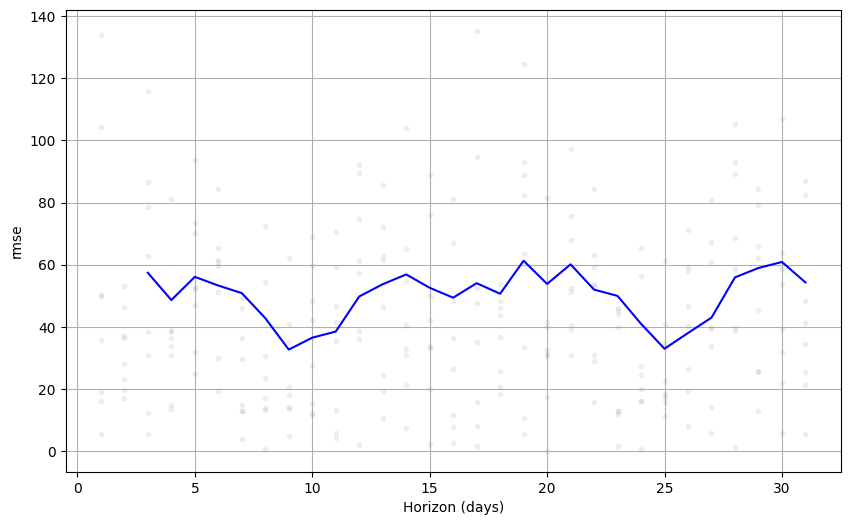

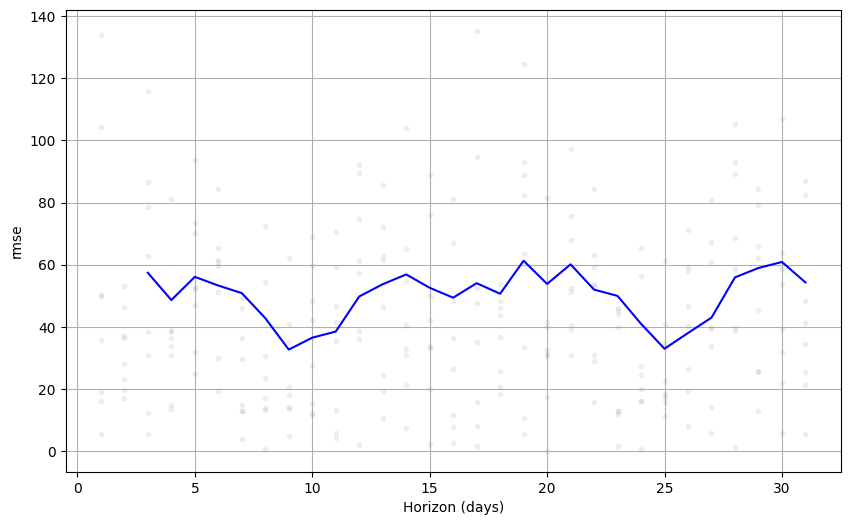

In [36]:
#plotting
plot_cross_validation_metric(df_cv, metric='rmse')

# Parameter Tuning

In [47]:
#Parameter Grid
param_grid = {'seasonality_mode': ["additive",multiplicativity "multiplicative"],
            'seasonality_prior_scale': [1,5,10,20],
              'holidays_prior_scale': [5,10,20,25],
              'changepoint_prior_scale': [0.005, 0.01, 0.05, 0.1]
             }
grid = ParameterGrid(param_grid)
len(list(grid))

128

In [48]:
#Store the results
rmse = []

#Loop
i = 1
for params in grid:
    print(f"{i} / {len(list(grid))}")
    # Model
    m = Prophet(holidays = holidays,
            seasonality_mode = params['seasonality_mode'],
            seasonality_prior_scale = params['seasonality_prior_scale'],
            holidays_prior_scale = params['holidays_prior_scale'],
            changepoint_prior_scale = params['changepoint_prior_scale'])
    m.add_regressor('Christmas')
    m.add_regressor('Temperature')
    m.add_regressor('Marketing')
    m.fit(df)
    
    # Cross Validation4
    df_cv = cross_validation(m, 
                        horizon='31 days',
                        period='16 days',
                        initial= '2043 days',
                        parallel = 'processes')

    # Measure error and store the result
    error = performance_metrics(df_cv)["rmse"].mean()
    rmse.append(error)
    i += 1

21:51:54 - cmdstanpy - INFO - Chain [1] start processing


1 / 128


21:51:55 - cmdstanpy - INFO - Chain [1] done processing
21:51:55 - cmdstanpy - INFO - Chain [1] start processing
21:51:55 - cmdstanpy - INFO - Chain [1] start processing
21:51:55 - cmdstanpy - INFO - Chain [1] start processing
21:51:55 - cmdstanpy - INFO - Chain [1] start processing
21:51:55 - cmdstanpy - INFO - Chain [1] start processing
21:51:55 - cmdstanpy - INFO - Chain [1] start processing
21:51:55 - cmdstanpy - INFO - Chain [1] start processing
21:51:55 - cmdstanpy - INFO - Chain [1] start processing
21:51:55 - cmdstanpy - INFO - Chain [1] done processing
21:51:55 - cmdstanpy - INFO - Chain [1] done processing
21:51:55 - cmdstanpy - INFO - Chain [1] done processing
21:51:55 - cmdstanpy - INFO - Chain [1] done processing
21:51:55 - cmdstanpy - INFO - Chain [1] done processing
21:51:55 - cmdstanpy - INFO - Chain [1] done processing
21:51:55 - cmdstanpy - INFO - Chain [1] done processing
21:51:55 - cmdstanpy - INFO - Chain [1] done processing
21:51:55 - cmdstanpy - INFO - Chain [1] 

2 / 128


21:51:56 - cmdstanpy - INFO - Chain [1] done processing
21:51:56 - cmdstanpy - INFO - Chain [1] start processing
21:51:56 - cmdstanpy - INFO - Chain [1] start processing
21:51:56 - cmdstanpy - INFO - Chain [1] start processing
21:51:56 - cmdstanpy - INFO - Chain [1] start processing
21:51:56 - cmdstanpy - INFO - Chain [1] start processing
21:51:56 - cmdstanpy - INFO - Chain [1] start processing
21:51:56 - cmdstanpy - INFO - Chain [1] start processing
21:51:56 - cmdstanpy - INFO - Chain [1] start processing
21:51:56 - cmdstanpy - INFO - Chain [1] done processing
21:51:56 - cmdstanpy - INFO - Chain [1] done processing
21:51:56 - cmdstanpy - INFO - Chain [1] done processing
21:51:56 - cmdstanpy - INFO - Chain [1] done processing
21:51:56 - cmdstanpy - INFO - Chain [1] done processing
21:51:56 - cmdstanpy - INFO - Chain [1] done processing
21:51:56 - cmdstanpy - INFO - Chain [1] done processing
21:51:56 - cmdstanpy - INFO - Chain [1] done processing
21:51:57 - cmdstanpy - INFO - Chain [1] 

3 / 128


21:51:57 - cmdstanpy - INFO - Chain [1] done processing
21:51:57 - cmdstanpy - INFO - Chain [1] start processing
21:51:57 - cmdstanpy - INFO - Chain [1] start processing
21:51:57 - cmdstanpy - INFO - Chain [1] start processing
21:51:57 - cmdstanpy - INFO - Chain [1] start processing
21:51:57 - cmdstanpy - INFO - Chain [1] start processing
21:51:57 - cmdstanpy - INFO - Chain [1] start processing
21:51:57 - cmdstanpy - INFO - Chain [1] start processing
21:51:57 - cmdstanpy - INFO - Chain [1] start processing
21:51:57 - cmdstanpy - INFO - Chain [1] done processing
21:51:57 - cmdstanpy - INFO - Chain [1] done processing
21:51:57 - cmdstanpy - INFO - Chain [1] done processing
21:51:57 - cmdstanpy - INFO - Chain [1] done processing
21:51:57 - cmdstanpy - INFO - Chain [1] done processing
21:51:57 - cmdstanpy - INFO - Chain [1] done processing
21:51:57 - cmdstanpy - INFO - Chain [1] done processing
21:51:58 - cmdstanpy - INFO - Chain [1] done processing
21:51:58 - cmdstanpy - INFO - Chain [1] 

4 / 128


21:51:58 - cmdstanpy - INFO - Chain [1] done processing
21:51:58 - cmdstanpy - INFO - Chain [1] start processing
21:51:58 - cmdstanpy - INFO - Chain [1] start processing
21:51:58 - cmdstanpy - INFO - Chain [1] start processing
21:51:58 - cmdstanpy - INFO - Chain [1] start processing
21:51:58 - cmdstanpy - INFO - Chain [1] start processing
21:51:58 - cmdstanpy - INFO - Chain [1] start processing
21:51:58 - cmdstanpy - INFO - Chain [1] start processing
21:51:58 - cmdstanpy - INFO - Chain [1] start processing
21:51:59 - cmdstanpy - INFO - Chain [1] done processing
21:51:59 - cmdstanpy - INFO - Chain [1] done processing
21:51:59 - cmdstanpy - INFO - Chain [1] done processing
21:51:59 - cmdstanpy - INFO - Chain [1] done processing
21:51:59 - cmdstanpy - INFO - Chain [1] done processing
21:51:59 - cmdstanpy - INFO - Chain [1] done processing
21:51:59 - cmdstanpy - INFO - Chain [1] done processing
21:51:59 - cmdstanpy - INFO - Chain [1] done processing
21:51:59 - cmdstanpy - INFO - Chain [1] 

5 / 128


21:51:59 - cmdstanpy - INFO - Chain [1] done processing
21:51:59 - cmdstanpy - INFO - Chain [1] start processing
21:51:59 - cmdstanpy - INFO - Chain [1] start processing
21:51:59 - cmdstanpy - INFO - Chain [1] start processing
21:51:59 - cmdstanpy - INFO - Chain [1] start processing
21:51:59 - cmdstanpy - INFO - Chain [1] start processing
21:51:59 - cmdstanpy - INFO - Chain [1] start processing
21:51:59 - cmdstanpy - INFO - Chain [1] start processing
21:51:59 - cmdstanpy - INFO - Chain [1] start processing
21:52:00 - cmdstanpy - INFO - Chain [1] done processing
21:52:00 - cmdstanpy - INFO - Chain [1] done processing
21:52:00 - cmdstanpy - INFO - Chain [1] done processing
21:52:00 - cmdstanpy - INFO - Chain [1] done processing
21:52:00 - cmdstanpy - INFO - Chain [1] done processing
21:52:00 - cmdstanpy - INFO - Chain [1] done processing
21:52:00 - cmdstanpy - INFO - Chain [1] done processing
21:52:00 - cmdstanpy - INFO - Chain [1] done processing
21:52:00 - cmdstanpy - INFO - Chain [1] 

6 / 128


21:52:00 - cmdstanpy - INFO - Chain [1] done processing
21:52:01 - cmdstanpy - INFO - Chain [1] start processing
21:52:01 - cmdstanpy - INFO - Chain [1] start processing
21:52:01 - cmdstanpy - INFO - Chain [1] start processing
21:52:01 - cmdstanpy - INFO - Chain [1] start processing
21:52:01 - cmdstanpy - INFO - Chain [1] start processing
21:52:01 - cmdstanpy - INFO - Chain [1] start processing
21:52:01 - cmdstanpy - INFO - Chain [1] start processing
21:52:01 - cmdstanpy - INFO - Chain [1] start processing
21:52:01 - cmdstanpy - INFO - Chain [1] done processing
21:52:01 - cmdstanpy - INFO - Chain [1] done processing
21:52:01 - cmdstanpy - INFO - Chain [1] done processing
21:52:01 - cmdstanpy - INFO - Chain [1] done processing
21:52:01 - cmdstanpy - INFO - Chain [1] done processing
21:52:01 - cmdstanpy - INFO - Chain [1] done processing
21:52:01 - cmdstanpy - INFO - Chain [1] done processing
21:52:01 - cmdstanpy - INFO - Chain [1] done processing
21:52:01 - cmdstanpy - INFO - Chain [1] 

7 / 128


21:52:02 - cmdstanpy - INFO - Chain [1] done processing
21:52:02 - cmdstanpy - INFO - Chain [1] start processing
21:52:02 - cmdstanpy - INFO - Chain [1] start processing
21:52:02 - cmdstanpy - INFO - Chain [1] start processing
21:52:02 - cmdstanpy - INFO - Chain [1] start processing
21:52:02 - cmdstanpy - INFO - Chain [1] start processing
21:52:02 - cmdstanpy - INFO - Chain [1] start processing
21:52:02 - cmdstanpy - INFO - Chain [1] start processing
21:52:02 - cmdstanpy - INFO - Chain [1] start processing
21:52:02 - cmdstanpy - INFO - Chain [1] done processing
21:52:02 - cmdstanpy - INFO - Chain [1] done processing
21:52:02 - cmdstanpy - INFO - Chain [1] done processing
21:52:02 - cmdstanpy - INFO - Chain [1] done processing
21:52:02 - cmdstanpy - INFO - Chain [1] done processing
21:52:02 - cmdstanpy - INFO - Chain [1] done processing
21:52:02 - cmdstanpy - INFO - Chain [1] done processing
21:52:02 - cmdstanpy - INFO - Chain [1] done processing
21:52:03 - cmdstanpy - INFO - Chain [1] 

8 / 128


21:52:03 - cmdstanpy - INFO - Chain [1] done processing
21:52:03 - cmdstanpy - INFO - Chain [1] start processing
21:52:03 - cmdstanpy - INFO - Chain [1] start processing
21:52:03 - cmdstanpy - INFO - Chain [1] start processing
21:52:03 - cmdstanpy - INFO - Chain [1] start processing
21:52:03 - cmdstanpy - INFO - Chain [1] start processing
21:52:03 - cmdstanpy - INFO - Chain [1] start processing
21:52:03 - cmdstanpy - INFO - Chain [1] start processing
21:52:03 - cmdstanpy - INFO - Chain [1] start processing
21:52:03 - cmdstanpy - INFO - Chain [1] done processing
21:52:03 - cmdstanpy - INFO - Chain [1] done processing
21:52:04 - cmdstanpy - INFO - Chain [1] done processing
21:52:04 - cmdstanpy - INFO - Chain [1] done processing
21:52:04 - cmdstanpy - INFO - Chain [1] done processing
21:52:04 - cmdstanpy - INFO - Chain [1] done processing
21:52:04 - cmdstanpy - INFO - Chain [1] done processing
21:52:04 - cmdstanpy - INFO - Chain [1] done processing
21:52:04 - cmdstanpy - INFO - Chain [1] 

9 / 128


21:52:04 - cmdstanpy - INFO - Chain [1] done processing
21:52:04 - cmdstanpy - INFO - Chain [1] start processing
21:52:04 - cmdstanpy - INFO - Chain [1] start processing
21:52:04 - cmdstanpy - INFO - Chain [1] start processing
21:52:04 - cmdstanpy - INFO - Chain [1] start processing
21:52:04 - cmdstanpy - INFO - Chain [1] start processing
21:52:04 - cmdstanpy - INFO - Chain [1] start processing
21:52:04 - cmdstanpy - INFO - Chain [1] start processing
21:52:04 - cmdstanpy - INFO - Chain [1] start processing
21:52:05 - cmdstanpy - INFO - Chain [1] done processing
21:52:05 - cmdstanpy - INFO - Chain [1] done processing
21:52:05 - cmdstanpy - INFO - Chain [1] done processing
21:52:05 - cmdstanpy - INFO - Chain [1] done processing
21:52:05 - cmdstanpy - INFO - Chain [1] done processing
21:52:05 - cmdstanpy - INFO - Chain [1] done processing
21:52:05 - cmdstanpy - INFO - Chain [1] done processing
21:52:05 - cmdstanpy - INFO - Chain [1] done processing
21:52:05 - cmdstanpy - INFO - Chain [1] 

10 / 128


21:52:05 - cmdstanpy - INFO - Chain [1] done processing
21:52:06 - cmdstanpy - INFO - Chain [1] start processing
21:52:06 - cmdstanpy - INFO - Chain [1] start processing
21:52:06 - cmdstanpy - INFO - Chain [1] start processing
21:52:06 - cmdstanpy - INFO - Chain [1] start processing
21:52:06 - cmdstanpy - INFO - Chain [1] start processing
21:52:06 - cmdstanpy - INFO - Chain [1] start processing
21:52:06 - cmdstanpy - INFO - Chain [1] start processing
21:52:06 - cmdstanpy - INFO - Chain [1] start processing
21:52:06 - cmdstanpy - INFO - Chain [1] done processing
21:52:06 - cmdstanpy - INFO - Chain [1] done processing
21:52:06 - cmdstanpy - INFO - Chain [1] done processing
21:52:06 - cmdstanpy - INFO - Chain [1] done processing
21:52:06 - cmdstanpy - INFO - Chain [1] done processing
21:52:06 - cmdstanpy - INFO - Chain [1] done processing
21:52:06 - cmdstanpy - INFO - Chain [1] done processing
21:52:06 - cmdstanpy - INFO - Chain [1] done processing
21:52:06 - cmdstanpy - INFO - Chain [1] 

11 / 128


21:52:06 - cmdstanpy - INFO - Chain [1] done processing
21:52:07 - cmdstanpy - INFO - Chain [1] start processing
21:52:07 - cmdstanpy - INFO - Chain [1] start processing
21:52:07 - cmdstanpy - INFO - Chain [1] start processing
21:52:07 - cmdstanpy - INFO - Chain [1] start processing
21:52:07 - cmdstanpy - INFO - Chain [1] start processing
21:52:07 - cmdstanpy - INFO - Chain [1] start processing
21:52:07 - cmdstanpy - INFO - Chain [1] start processing
21:52:07 - cmdstanpy - INFO - Chain [1] start processing
21:52:07 - cmdstanpy - INFO - Chain [1] done processing
21:52:07 - cmdstanpy - INFO - Chain [1] done processing
21:52:07 - cmdstanpy - INFO - Chain [1] done processing
21:52:07 - cmdstanpy - INFO - Chain [1] done processing
21:52:07 - cmdstanpy - INFO - Chain [1] done processing
21:52:07 - cmdstanpy - INFO - Chain [1] done processing
21:52:07 - cmdstanpy - INFO - Chain [1] done processing
21:52:07 - cmdstanpy - INFO - Chain [1] done processing
21:52:08 - cmdstanpy - INFO - Chain [1] 

12 / 128


21:52:08 - cmdstanpy - INFO - Chain [1] done processing
21:52:08 - cmdstanpy - INFO - Chain [1] start processing
21:52:08 - cmdstanpy - INFO - Chain [1] start processing
21:52:08 - cmdstanpy - INFO - Chain [1] start processing
21:52:08 - cmdstanpy - INFO - Chain [1] start processing
21:52:08 - cmdstanpy - INFO - Chain [1] start processing
21:52:08 - cmdstanpy - INFO - Chain [1] start processing
21:52:08 - cmdstanpy - INFO - Chain [1] start processing
21:52:08 - cmdstanpy - INFO - Chain [1] done processing
21:52:08 - cmdstanpy - INFO - Chain [1] start processing
21:52:08 - cmdstanpy - INFO - Chain [1] done processing
21:52:08 - cmdstanpy - INFO - Chain [1] done processing
21:52:08 - cmdstanpy - INFO - Chain [1] done processing
21:52:08 - cmdstanpy - INFO - Chain [1] done processing
21:52:08 - cmdstanpy - INFO - Chain [1] done processing
21:52:08 - cmdstanpy - INFO - Chain [1] done processing
21:52:08 - cmdstanpy - INFO - Chain [1] done processing
21:52:09 - cmdstanpy - INFO - Chain [1] 

13 / 128


21:52:09 - cmdstanpy - INFO - Chain [1] done processing
21:52:09 - cmdstanpy - INFO - Chain [1] start processing
21:52:09 - cmdstanpy - INFO - Chain [1] start processing
21:52:09 - cmdstanpy - INFO - Chain [1] start processing
21:52:09 - cmdstanpy - INFO - Chain [1] start processing
21:52:09 - cmdstanpy - INFO - Chain [1] start processing
21:52:09 - cmdstanpy - INFO - Chain [1] start processing
21:52:09 - cmdstanpy - INFO - Chain [1] start processing
21:52:09 - cmdstanpy - INFO - Chain [1] start processing
21:52:09 - cmdstanpy - INFO - Chain [1] done processing
21:52:09 - cmdstanpy - INFO - Chain [1] done processing
21:52:09 - cmdstanpy - INFO - Chain [1] done processing
21:52:10 - cmdstanpy - INFO - Chain [1] done processing
21:52:10 - cmdstanpy - INFO - Chain [1] done processing
21:52:10 - cmdstanpy - INFO - Chain [1] done processing
21:52:10 - cmdstanpy - INFO - Chain [1] done processing
21:52:10 - cmdstanpy - INFO - Chain [1] done processing


14 / 128


21:52:10 - cmdstanpy - INFO - Chain [1] start processing
21:52:10 - cmdstanpy - INFO - Chain [1] done processing
21:52:10 - cmdstanpy - INFO - Chain [1] start processing
21:52:10 - cmdstanpy - INFO - Chain [1] start processing
21:52:10 - cmdstanpy - INFO - Chain [1] start processing
21:52:10 - cmdstanpy - INFO - Chain [1] start processing
21:52:10 - cmdstanpy - INFO - Chain [1] start processing
21:52:10 - cmdstanpy - INFO - Chain [1] start processing
21:52:10 - cmdstanpy - INFO - Chain [1] start processing
21:52:10 - cmdstanpy - INFO - Chain [1] start processing
21:52:11 - cmdstanpy - INFO - Chain [1] done processing
21:52:11 - cmdstanpy - INFO - Chain [1] done processing
21:52:11 - cmdstanpy - INFO - Chain [1] done processing
21:52:11 - cmdstanpy - INFO - Chain [1] done processing
21:52:11 - cmdstanpy - INFO - Chain [1] done processing
21:52:11 - cmdstanpy - INFO - Chain [1] done processing
21:52:11 - cmdstanpy - INFO - Chain [1] done processing
21:52:11 - cmdstanpy - INFO - Chain [1]

15 / 128


21:52:11 - cmdstanpy - INFO - Chain [1] done processing
21:52:11 - cmdstanpy - INFO - Chain [1] start processing
21:52:11 - cmdstanpy - INFO - Chain [1] start processing
21:52:11 - cmdstanpy - INFO - Chain [1] start processing
21:52:11 - cmdstanpy - INFO - Chain [1] start processing
21:52:11 - cmdstanpy - INFO - Chain [1] start processing
21:52:11 - cmdstanpy - INFO - Chain [1] start processing
21:52:11 - cmdstanpy - INFO - Chain [1] start processing
21:52:11 - cmdstanpy - INFO - Chain [1] start processing
21:52:12 - cmdstanpy - INFO - Chain [1] done processing
21:52:12 - cmdstanpy - INFO - Chain [1] done processing
21:52:12 - cmdstanpy - INFO - Chain [1] done processing
21:52:12 - cmdstanpy - INFO - Chain [1] done processing
21:52:12 - cmdstanpy - INFO - Chain [1] done processing
21:52:12 - cmdstanpy - INFO - Chain [1] done processing
21:52:12 - cmdstanpy - INFO - Chain [1] done processing
21:52:12 - cmdstanpy - INFO - Chain [1] done processing
21:52:12 - cmdstanpy - INFO - Chain [1] 

16 / 128


21:52:12 - cmdstanpy - INFO - Chain [1] done processing
21:52:13 - cmdstanpy - INFO - Chain [1] start processing
21:52:13 - cmdstanpy - INFO - Chain [1] start processing
21:52:13 - cmdstanpy - INFO - Chain [1] start processing
21:52:13 - cmdstanpy - INFO - Chain [1] start processing
21:52:13 - cmdstanpy - INFO - Chain [1] start processing
21:52:13 - cmdstanpy - INFO - Chain [1] start processing
21:52:13 - cmdstanpy - INFO - Chain [1] start processing
21:52:13 - cmdstanpy - INFO - Chain [1] start processing
21:52:13 - cmdstanpy - INFO - Chain [1] done processing
21:52:13 - cmdstanpy - INFO - Chain [1] done processing
21:52:13 - cmdstanpy - INFO - Chain [1] done processing
21:52:13 - cmdstanpy - INFO - Chain [1] done processing
21:52:13 - cmdstanpy - INFO - Chain [1] done processing
21:52:13 - cmdstanpy - INFO - Chain [1] done processing
21:52:13 - cmdstanpy - INFO - Chain [1] done processing
21:52:13 - cmdstanpy - INFO - Chain [1] done processing
21:52:13 - cmdstanpy - INFO - Chain [1] 

17 / 128


21:52:14 - cmdstanpy - INFO - Chain [1] done processing
21:52:14 - cmdstanpy - INFO - Chain [1] start processing
21:52:14 - cmdstanpy - INFO - Chain [1] start processing
21:52:14 - cmdstanpy - INFO - Chain [1] start processing
21:52:14 - cmdstanpy - INFO - Chain [1] start processing
21:52:14 - cmdstanpy - INFO - Chain [1] start processing
21:52:14 - cmdstanpy - INFO - Chain [1] start processing
21:52:14 - cmdstanpy - INFO - Chain [1] start processing
21:52:14 - cmdstanpy - INFO - Chain [1] start processing
21:52:14 - cmdstanpy - INFO - Chain [1] done processing
21:52:14 - cmdstanpy - INFO - Chain [1] done processing
21:52:14 - cmdstanpy - INFO - Chain [1] done processing
21:52:14 - cmdstanpy - INFO - Chain [1] done processing
21:52:14 - cmdstanpy - INFO - Chain [1] done processing
21:52:14 - cmdstanpy - INFO - Chain [1] done processing
21:52:14 - cmdstanpy - INFO - Chain [1] done processing
21:52:14 - cmdstanpy - INFO - Chain [1] done processing
21:52:15 - cmdstanpy - INFO - Chain [1] 

18 / 128


21:52:15 - cmdstanpy - INFO - Chain [1] done processing
21:52:15 - cmdstanpy - INFO - Chain [1] start processing
21:52:15 - cmdstanpy - INFO - Chain [1] start processing
21:52:15 - cmdstanpy - INFO - Chain [1] start processing
21:52:15 - cmdstanpy - INFO - Chain [1] start processing
21:52:15 - cmdstanpy - INFO - Chain [1] start processing
21:52:15 - cmdstanpy - INFO - Chain [1] start processing
21:52:15 - cmdstanpy - INFO - Chain [1] start processing
21:52:15 - cmdstanpy - INFO - Chain [1] start processing
21:52:15 - cmdstanpy - INFO - Chain [1] done processing
21:52:15 - cmdstanpy - INFO - Chain [1] done processing
21:52:15 - cmdstanpy - INFO - Chain [1] done processing
21:52:15 - cmdstanpy - INFO - Chain [1] done processing
21:52:15 - cmdstanpy - INFO - Chain [1] done processing
21:52:15 - cmdstanpy - INFO - Chain [1] done processing
21:52:16 - cmdstanpy - INFO - Chain [1] done processing
21:52:16 - cmdstanpy - INFO - Chain [1] done processing
21:52:16 - cmdstanpy - INFO - Chain [1] 

19 / 128


21:52:16 - cmdstanpy - INFO - Chain [1] done processing
21:52:16 - cmdstanpy - INFO - Chain [1] start processing
21:52:16 - cmdstanpy - INFO - Chain [1] start processing
21:52:16 - cmdstanpy - INFO - Chain [1] start processing
21:52:16 - cmdstanpy - INFO - Chain [1] start processing
21:52:16 - cmdstanpy - INFO - Chain [1] start processing
21:52:16 - cmdstanpy - INFO - Chain [1] start processing
21:52:16 - cmdstanpy - INFO - Chain [1] start processing
21:52:16 - cmdstanpy - INFO - Chain [1] start processing
21:52:16 - cmdstanpy - INFO - Chain [1] done processing
21:52:17 - cmdstanpy - INFO - Chain [1] done processing
21:52:17 - cmdstanpy - INFO - Chain [1] done processing
21:52:17 - cmdstanpy - INFO - Chain [1] done processing
21:52:17 - cmdstanpy - INFO - Chain [1] done processing
21:52:17 - cmdstanpy - INFO - Chain [1] done processing
21:52:17 - cmdstanpy - INFO - Chain [1] done processing
21:52:17 - cmdstanpy - INFO - Chain [1] done processing
21:52:17 - cmdstanpy - INFO - Chain [1] 

20 / 128


21:52:17 - cmdstanpy - INFO - Chain [1] done processing
21:52:17 - cmdstanpy - INFO - Chain [1] start processing
21:52:17 - cmdstanpy - INFO - Chain [1] start processing
21:52:17 - cmdstanpy - INFO - Chain [1] start processing
21:52:17 - cmdstanpy - INFO - Chain [1] start processing
21:52:17 - cmdstanpy - INFO - Chain [1] start processing
21:52:17 - cmdstanpy - INFO - Chain [1] start processing
21:52:18 - cmdstanpy - INFO - Chain [1] start processing
21:52:18 - cmdstanpy - INFO - Chain [1] start processing
21:52:18 - cmdstanpy - INFO - Chain [1] done processing
21:52:18 - cmdstanpy - INFO - Chain [1] done processing
21:52:18 - cmdstanpy - INFO - Chain [1] done processing
21:52:18 - cmdstanpy - INFO - Chain [1] done processing
21:52:18 - cmdstanpy - INFO - Chain [1] done processing
21:52:18 - cmdstanpy - INFO - Chain [1] done processing
21:52:18 - cmdstanpy - INFO - Chain [1] done processing
21:52:18 - cmdstanpy - INFO - Chain [1] done processing
21:52:18 - cmdstanpy - INFO - Chain [1] 

21 / 128


21:52:18 - cmdstanpy - INFO - Chain [1] done processing
21:52:18 - cmdstanpy - INFO - Chain [1] start processing
21:52:18 - cmdstanpy - INFO - Chain [1] start processing
21:52:18 - cmdstanpy - INFO - Chain [1] start processing
21:52:18 - cmdstanpy - INFO - Chain [1] start processing
21:52:18 - cmdstanpy - INFO - Chain [1] start processing
21:52:18 - cmdstanpy - INFO - Chain [1] start processing
21:52:18 - cmdstanpy - INFO - Chain [1] start processing
21:52:18 - cmdstanpy - INFO - Chain [1] start processing
21:52:19 - cmdstanpy - INFO - Chain [1] done processing
21:52:19 - cmdstanpy - INFO - Chain [1] done processing
21:52:19 - cmdstanpy - INFO - Chain [1] done processing
21:52:19 - cmdstanpy - INFO - Chain [1] done processing
21:52:19 - cmdstanpy - INFO - Chain [1] done processing
21:52:19 - cmdstanpy - INFO - Chain [1] done processing
21:52:19 - cmdstanpy - INFO - Chain [1] done processing
21:52:19 - cmdstanpy - INFO - Chain [1] done processing
21:52:19 - cmdstanpy - INFO - Chain [1] 

22 / 128


21:52:19 - cmdstanpy - INFO - Chain [1] done processing
21:52:20 - cmdstanpy - INFO - Chain [1] start processing
21:52:20 - cmdstanpy - INFO - Chain [1] start processing
21:52:20 - cmdstanpy - INFO - Chain [1] start processing
21:52:20 - cmdstanpy - INFO - Chain [1] start processing
21:52:20 - cmdstanpy - INFO - Chain [1] start processing
21:52:20 - cmdstanpy - INFO - Chain [1] start processing
21:52:20 - cmdstanpy - INFO - Chain [1] start processing
21:52:20 - cmdstanpy - INFO - Chain [1] start processing
21:52:20 - cmdstanpy - INFO - Chain [1] done processing
21:52:20 - cmdstanpy - INFO - Chain [1] done processing
21:52:20 - cmdstanpy - INFO - Chain [1] done processing
21:52:20 - cmdstanpy - INFO - Chain [1] done processing
21:52:20 - cmdstanpy - INFO - Chain [1] done processing
21:52:20 - cmdstanpy - INFO - Chain [1] done processing
21:52:20 - cmdstanpy - INFO - Chain [1] done processing
21:52:20 - cmdstanpy - INFO - Chain [1] done processing
21:52:20 - cmdstanpy - INFO - Chain [1] 

23 / 128


21:52:21 - cmdstanpy - INFO - Chain [1] done processing
21:52:21 - cmdstanpy - INFO - Chain [1] start processing
21:52:21 - cmdstanpy - INFO - Chain [1] start processing
21:52:21 - cmdstanpy - INFO - Chain [1] start processing
21:52:21 - cmdstanpy - INFO - Chain [1] start processing
21:52:21 - cmdstanpy - INFO - Chain [1] start processing
21:52:21 - cmdstanpy - INFO - Chain [1] start processing
21:52:21 - cmdstanpy - INFO - Chain [1] start processing
21:52:21 - cmdstanpy - INFO - Chain [1] start processing
21:52:21 - cmdstanpy - INFO - Chain [1] done processing
21:52:21 - cmdstanpy - INFO - Chain [1] done processing
21:52:21 - cmdstanpy - INFO - Chain [1] done processing
21:52:21 - cmdstanpy - INFO - Chain [1] done processing
21:52:21 - cmdstanpy - INFO - Chain [1] done processing
21:52:21 - cmdstanpy - INFO - Chain [1] done processing
21:52:21 - cmdstanpy - INFO - Chain [1] done processing
21:52:22 - cmdstanpy - INFO - Chain [1] done processing
21:52:22 - cmdstanpy - INFO - Chain [1] 

24 / 128


21:52:22 - cmdstanpy - INFO - Chain [1] done processing
21:52:22 - cmdstanpy - INFO - Chain [1] start processing
21:52:22 - cmdstanpy - INFO - Chain [1] start processing
21:52:22 - cmdstanpy - INFO - Chain [1] start processing
21:52:22 - cmdstanpy - INFO - Chain [1] start processing
21:52:22 - cmdstanpy - INFO - Chain [1] start processing
21:52:22 - cmdstanpy - INFO - Chain [1] start processing
21:52:22 - cmdstanpy - INFO - Chain [1] start processing
21:52:22 - cmdstanpy - INFO - Chain [1] start processing
21:52:22 - cmdstanpy - INFO - Chain [1] done processing
21:52:23 - cmdstanpy - INFO - Chain [1] done processing
21:52:23 - cmdstanpy - INFO - Chain [1] done processing
21:52:23 - cmdstanpy - INFO - Chain [1] done processing
21:52:23 - cmdstanpy - INFO - Chain [1] done processing
21:52:23 - cmdstanpy - INFO - Chain [1] done processing
21:52:23 - cmdstanpy - INFO - Chain [1] done processing
21:52:23 - cmdstanpy - INFO - Chain [1] done processing
21:52:23 - cmdstanpy - INFO - Chain [1] 

25 / 128


21:52:23 - cmdstanpy - INFO - Chain [1] done processing
21:52:23 - cmdstanpy - INFO - Chain [1] start processing
21:52:23 - cmdstanpy - INFO - Chain [1] start processing
21:52:23 - cmdstanpy - INFO - Chain [1] start processing
21:52:23 - cmdstanpy - INFO - Chain [1] start processing
21:52:23 - cmdstanpy - INFO - Chain [1] start processing
21:52:23 - cmdstanpy - INFO - Chain [1] start processing
21:52:23 - cmdstanpy - INFO - Chain [1] start processing
21:52:23 - cmdstanpy - INFO - Chain [1] start processing
21:52:24 - cmdstanpy - INFO - Chain [1] done processing
21:52:24 - cmdstanpy - INFO - Chain [1] done processing
21:52:24 - cmdstanpy - INFO - Chain [1] done processing
21:52:24 - cmdstanpy - INFO - Chain [1] done processing
21:52:24 - cmdstanpy - INFO - Chain [1] done processing
21:52:24 - cmdstanpy - INFO - Chain [1] done processing
21:52:24 - cmdstanpy - INFO - Chain [1] done processing
21:52:24 - cmdstanpy - INFO - Chain [1] done processing
21:52:24 - cmdstanpy - INFO - Chain [1] 

26 / 128


21:52:24 - cmdstanpy - INFO - Chain [1] done processing
21:52:25 - cmdstanpy - INFO - Chain [1] start processing
21:52:25 - cmdstanpy - INFO - Chain [1] start processing
21:52:25 - cmdstanpy - INFO - Chain [1] start processing
21:52:25 - cmdstanpy - INFO - Chain [1] start processing
21:52:25 - cmdstanpy - INFO - Chain [1] start processing
21:52:25 - cmdstanpy - INFO - Chain [1] start processing
21:52:25 - cmdstanpy - INFO - Chain [1] start processing
21:52:25 - cmdstanpy - INFO - Chain [1] start processing
21:52:25 - cmdstanpy - INFO - Chain [1] done processing
21:52:25 - cmdstanpy - INFO - Chain [1] done processing
21:52:25 - cmdstanpy - INFO - Chain [1] done processing
21:52:25 - cmdstanpy - INFO - Chain [1] done processing
21:52:25 - cmdstanpy - INFO - Chain [1] done processing
21:52:25 - cmdstanpy - INFO - Chain [1] done processing
21:52:25 - cmdstanpy - INFO - Chain [1] done processing
21:52:25 - cmdstanpy - INFO - Chain [1] done processing
21:52:25 - cmdstanpy - INFO - Chain [1] 

27 / 128


21:52:26 - cmdstanpy - INFO - Chain [1] done processing
21:52:26 - cmdstanpy - INFO - Chain [1] start processing
21:52:26 - cmdstanpy - INFO - Chain [1] start processing
21:52:26 - cmdstanpy - INFO - Chain [1] start processing
21:52:26 - cmdstanpy - INFO - Chain [1] start processing
21:52:26 - cmdstanpy - INFO - Chain [1] start processing
21:52:26 - cmdstanpy - INFO - Chain [1] start processing
21:52:26 - cmdstanpy - INFO - Chain [1] start processing
21:52:26 - cmdstanpy - INFO - Chain [1] start processing
21:52:26 - cmdstanpy - INFO - Chain [1] done processing
21:52:26 - cmdstanpy - INFO - Chain [1] done processing
21:52:26 - cmdstanpy - INFO - Chain [1] done processing
21:52:26 - cmdstanpy - INFO - Chain [1] done processing
21:52:26 - cmdstanpy - INFO - Chain [1] done processing
21:52:26 - cmdstanpy - INFO - Chain [1] done processing
21:52:26 - cmdstanpy - INFO - Chain [1] done processing
21:52:26 - cmdstanpy - INFO - Chain [1] done processing


28 / 128


21:52:27 - cmdstanpy - INFO - Chain [1] start processing
21:52:27 - cmdstanpy - INFO - Chain [1] done processing
21:52:27 - cmdstanpy - INFO - Chain [1] start processing
21:52:27 - cmdstanpy - INFO - Chain [1] start processing
21:52:27 - cmdstanpy - INFO - Chain [1] start processing
21:52:27 - cmdstanpy - INFO - Chain [1] start processing
21:52:27 - cmdstanpy - INFO - Chain [1] start processing
21:52:27 - cmdstanpy - INFO - Chain [1] start processing
21:52:27 - cmdstanpy - INFO - Chain [1] start processing
21:52:27 - cmdstanpy - INFO - Chain [1] start processing
21:52:27 - cmdstanpy - INFO - Chain [1] done processing
21:52:27 - cmdstanpy - INFO - Chain [1] done processing
21:52:27 - cmdstanpy - INFO - Chain [1] done processing
21:52:27 - cmdstanpy - INFO - Chain [1] done processing
21:52:27 - cmdstanpy - INFO - Chain [1] done processing
21:52:27 - cmdstanpy - INFO - Chain [1] done processing
21:52:27 - cmdstanpy - INFO - Chain [1] done processing
21:52:28 - cmdstanpy - INFO - Chain [1]

29 / 128


21:52:28 - cmdstanpy - INFO - Chain [1] done processing
21:52:28 - cmdstanpy - INFO - Chain [1] start processing
21:52:28 - cmdstanpy - INFO - Chain [1] start processing
21:52:28 - cmdstanpy - INFO - Chain [1] start processing
21:52:28 - cmdstanpy - INFO - Chain [1] start processing
21:52:28 - cmdstanpy - INFO - Chain [1] start processing
21:52:28 - cmdstanpy - INFO - Chain [1] start processing
21:52:28 - cmdstanpy - INFO - Chain [1] start processing
21:52:28 - cmdstanpy - INFO - Chain [1] start processing
21:52:28 - cmdstanpy - INFO - Chain [1] done processing
21:52:28 - cmdstanpy - INFO - Chain [1] done processing
21:52:28 - cmdstanpy - INFO - Chain [1] done processing
21:52:28 - cmdstanpy - INFO - Chain [1] done processing
21:52:28 - cmdstanpy - INFO - Chain [1] done processing
21:52:28 - cmdstanpy - INFO - Chain [1] done processing
21:52:29 - cmdstanpy - INFO - Chain [1] done processing
21:52:29 - cmdstanpy - INFO - Chain [1] done processing
21:52:29 - cmdstanpy - INFO - Chain [1] 

30 / 128


21:52:29 - cmdstanpy - INFO - Chain [1] done processing
21:52:29 - cmdstanpy - INFO - Chain [1] start processing
21:52:29 - cmdstanpy - INFO - Chain [1] start processing
21:52:29 - cmdstanpy - INFO - Chain [1] start processing
21:52:29 - cmdstanpy - INFO - Chain [1] start processing
21:52:29 - cmdstanpy - INFO - Chain [1] start processing
21:52:29 - cmdstanpy - INFO - Chain [1] start processing
21:52:29 - cmdstanpy - INFO - Chain [1] start processing
21:52:29 - cmdstanpy - INFO - Chain [1] start processing
21:52:29 - cmdstanpy - INFO - Chain [1] done processing
21:52:29 - cmdstanpy - INFO - Chain [1] done processing
21:52:29 - cmdstanpy - INFO - Chain [1] done processing
21:52:29 - cmdstanpy - INFO - Chain [1] done processing
21:52:30 - cmdstanpy - INFO - Chain [1] done processing
21:52:30 - cmdstanpy - INFO - Chain [1] done processing
21:52:30 - cmdstanpy - INFO - Chain [1] done processing
21:52:30 - cmdstanpy - INFO - Chain [1] done processing
21:52:30 - cmdstanpy - INFO - Chain [1] 

31 / 128


21:52:30 - cmdstanpy - INFO - Chain [1] done processing
21:52:30 - cmdstanpy - INFO - Chain [1] start processing
21:52:30 - cmdstanpy - INFO - Chain [1] start processing
21:52:30 - cmdstanpy - INFO - Chain [1] start processing
21:52:30 - cmdstanpy - INFO - Chain [1] start processing
21:52:30 - cmdstanpy - INFO - Chain [1] start processing
21:52:30 - cmdstanpy - INFO - Chain [1] start processing
21:52:30 - cmdstanpy - INFO - Chain [1] start processing
21:52:30 - cmdstanpy - INFO - Chain [1] start processing
21:52:31 - cmdstanpy - INFO - Chain [1] done processing
21:52:31 - cmdstanpy - INFO - Chain [1] done processing
21:52:31 - cmdstanpy - INFO - Chain [1] done processing
21:52:31 - cmdstanpy - INFO - Chain [1] done processing
21:52:31 - cmdstanpy - INFO - Chain [1] done processing
21:52:31 - cmdstanpy - INFO - Chain [1] done processing
21:52:31 - cmdstanpy - INFO - Chain [1] done processing
21:52:31 - cmdstanpy - INFO - Chain [1] done processing
21:52:31 - cmdstanpy - INFO - Chain [1] 

32 / 128


21:52:31 - cmdstanpy - INFO - Chain [1] done processing
21:52:31 - cmdstanpy - INFO - Chain [1] start processing
21:52:31 - cmdstanpy - INFO - Chain [1] start processing
21:52:31 - cmdstanpy - INFO - Chain [1] start processing
21:52:31 - cmdstanpy - INFO - Chain [1] start processing
21:52:31 - cmdstanpy - INFO - Chain [1] start processing
21:52:31 - cmdstanpy - INFO - Chain [1] start processing
21:52:31 - cmdstanpy - INFO - Chain [1] start processing
21:52:31 - cmdstanpy - INFO - Chain [1] start processing
21:52:32 - cmdstanpy - INFO - Chain [1] done processing
21:52:32 - cmdstanpy - INFO - Chain [1] done processing
21:52:32 - cmdstanpy - INFO - Chain [1] done processing
21:52:32 - cmdstanpy - INFO - Chain [1] done processing
21:52:32 - cmdstanpy - INFO - Chain [1] done processing
21:52:32 - cmdstanpy - INFO - Chain [1] done processing
21:52:32 - cmdstanpy - INFO - Chain [1] done processing
21:52:32 - cmdstanpy - INFO - Chain [1] done processing
21:52:32 - cmdstanpy - INFO - Chain [1] 

33 / 128


21:52:32 - cmdstanpy - INFO - Chain [1] done processing
21:52:33 - cmdstanpy - INFO - Chain [1] start processing
21:52:33 - cmdstanpy - INFO - Chain [1] start processing
21:52:33 - cmdstanpy - INFO - Chain [1] start processing
21:52:33 - cmdstanpy - INFO - Chain [1] start processing
21:52:33 - cmdstanpy - INFO - Chain [1] start processing
21:52:33 - cmdstanpy - INFO - Chain [1] start processing
21:52:33 - cmdstanpy - INFO - Chain [1] start processing
21:52:33 - cmdstanpy - INFO - Chain [1] start processing
21:52:33 - cmdstanpy - INFO - Chain [1] done processing
21:52:33 - cmdstanpy - INFO - Chain [1] done processing
21:52:33 - cmdstanpy - INFO - Chain [1] done processing
21:52:33 - cmdstanpy - INFO - Chain [1] done processing
21:52:33 - cmdstanpy - INFO - Chain [1] done processing
21:52:33 - cmdstanpy - INFO - Chain [1] done processing
21:52:33 - cmdstanpy - INFO - Chain [1] done processing
21:52:33 - cmdstanpy - INFO - Chain [1] done processing
21:52:33 - cmdstanpy - INFO - Chain [1] 

34 / 128


21:52:34 - cmdstanpy - INFO - Chain [1] done processing
21:52:34 - cmdstanpy - INFO - Chain [1] start processing
21:52:34 - cmdstanpy - INFO - Chain [1] start processing
21:52:34 - cmdstanpy - INFO - Chain [1] start processing
21:52:34 - cmdstanpy - INFO - Chain [1] start processing
21:52:34 - cmdstanpy - INFO - Chain [1] start processing
21:52:34 - cmdstanpy - INFO - Chain [1] start processing
21:52:34 - cmdstanpy - INFO - Chain [1] start processing
21:52:34 - cmdstanpy - INFO - Chain [1] start processing
21:52:34 - cmdstanpy - INFO - Chain [1] done processing
21:52:34 - cmdstanpy - INFO - Chain [1] done processing
21:52:34 - cmdstanpy - INFO - Chain [1] done processing
21:52:34 - cmdstanpy - INFO - Chain [1] done processing
21:52:34 - cmdstanpy - INFO - Chain [1] done processing
21:52:34 - cmdstanpy - INFO - Chain [1] done processing
21:52:34 - cmdstanpy - INFO - Chain [1] done processing
21:52:34 - cmdstanpy - INFO - Chain [1] done processing
21:52:35 - cmdstanpy - INFO - Chain [1] 

35 / 128


21:52:35 - cmdstanpy - INFO - Chain [1] done processing
21:52:35 - cmdstanpy - INFO - Chain [1] start processing
21:52:35 - cmdstanpy - INFO - Chain [1] start processing
21:52:35 - cmdstanpy - INFO - Chain [1] start processing
21:52:35 - cmdstanpy - INFO - Chain [1] start processing
21:52:35 - cmdstanpy - INFO - Chain [1] start processing
21:52:35 - cmdstanpy - INFO - Chain [1] start processing
21:52:35 - cmdstanpy - INFO - Chain [1] start processing
21:52:35 - cmdstanpy - INFO - Chain [1] start processing
21:52:36 - cmdstanpy - INFO - Chain [1] done processing
21:52:36 - cmdstanpy - INFO - Chain [1] done processing
21:52:36 - cmdstanpy - INFO - Chain [1] done processing
21:52:36 - cmdstanpy - INFO - Chain [1] done processing
21:52:36 - cmdstanpy - INFO - Chain [1] done processing
21:52:36 - cmdstanpy - INFO - Chain [1] done processing
21:52:36 - cmdstanpy - INFO - Chain [1] done processing
21:52:36 - cmdstanpy - INFO - Chain [1] done processing
21:52:36 - cmdstanpy - INFO - Chain [1] 

36 / 128


21:52:36 - cmdstanpy - INFO - Chain [1] done processing
21:52:36 - cmdstanpy - INFO - Chain [1] start processing
21:52:36 - cmdstanpy - INFO - Chain [1] start processing
21:52:36 - cmdstanpy - INFO - Chain [1] start processing
21:52:36 - cmdstanpy - INFO - Chain [1] start processing
21:52:36 - cmdstanpy - INFO - Chain [1] start processing
21:52:36 - cmdstanpy - INFO - Chain [1] start processing
21:52:36 - cmdstanpy - INFO - Chain [1] start processing
21:52:36 - cmdstanpy - INFO - Chain [1] start processing
21:52:37 - cmdstanpy - INFO - Chain [1] done processing
21:52:37 - cmdstanpy - INFO - Chain [1] done processing
21:52:37 - cmdstanpy - INFO - Chain [1] done processing
21:52:37 - cmdstanpy - INFO - Chain [1] done processing
21:52:37 - cmdstanpy - INFO - Chain [1] done processing
21:52:37 - cmdstanpy - INFO - Chain [1] done processing
21:52:37 - cmdstanpy - INFO - Chain [1] done processing
21:52:37 - cmdstanpy - INFO - Chain [1] done processing
21:52:37 - cmdstanpy - INFO - Chain [1] 

37 / 128


21:52:37 - cmdstanpy - INFO - Chain [1] done processing
21:52:38 - cmdstanpy - INFO - Chain [1] start processing
21:52:38 - cmdstanpy - INFO - Chain [1] start processing
21:52:38 - cmdstanpy - INFO - Chain [1] start processing
21:52:38 - cmdstanpy - INFO - Chain [1] start processing
21:52:38 - cmdstanpy - INFO - Chain [1] start processing
21:52:38 - cmdstanpy - INFO - Chain [1] start processing
21:52:38 - cmdstanpy - INFO - Chain [1] start processing
21:52:38 - cmdstanpy - INFO - Chain [1] start processing
21:52:38 - cmdstanpy - INFO - Chain [1] done processing
21:52:38 - cmdstanpy - INFO - Chain [1] done processing
21:52:38 - cmdstanpy - INFO - Chain [1] done processing
21:52:38 - cmdstanpy - INFO - Chain [1] done processing
21:52:38 - cmdstanpy - INFO - Chain [1] done processing
21:52:38 - cmdstanpy - INFO - Chain [1] done processing
21:52:38 - cmdstanpy - INFO - Chain [1] done processing
21:52:38 - cmdstanpy - INFO - Chain [1] done processing
21:52:38 - cmdstanpy - INFO - Chain [1] 

38 / 128


21:52:39 - cmdstanpy - INFO - Chain [1] done processing
21:52:39 - cmdstanpy - INFO - Chain [1] start processing
21:52:39 - cmdstanpy - INFO - Chain [1] start processing
21:52:39 - cmdstanpy - INFO - Chain [1] start processing
21:52:39 - cmdstanpy - INFO - Chain [1] start processing
21:52:39 - cmdstanpy - INFO - Chain [1] start processing
21:52:39 - cmdstanpy - INFO - Chain [1] start processing
21:52:39 - cmdstanpy - INFO - Chain [1] start processing
21:52:39 - cmdstanpy - INFO - Chain [1] start processing
21:52:39 - cmdstanpy - INFO - Chain [1] done processing
21:52:39 - cmdstanpy - INFO - Chain [1] done processing
21:52:39 - cmdstanpy - INFO - Chain [1] done processing
21:52:39 - cmdstanpy - INFO - Chain [1] done processing
21:52:39 - cmdstanpy - INFO - Chain [1] done processing
21:52:39 - cmdstanpy - INFO - Chain [1] done processing
21:52:39 - cmdstanpy - INFO - Chain [1] done processing
21:52:40 - cmdstanpy - INFO - Chain [1] done processing
21:52:40 - cmdstanpy - INFO - Chain [1] 

39 / 128


21:52:40 - cmdstanpy - INFO - Chain [1] done processing
21:52:40 - cmdstanpy - INFO - Chain [1] start processing
21:52:40 - cmdstanpy - INFO - Chain [1] start processing
21:52:40 - cmdstanpy - INFO - Chain [1] start processing
21:52:40 - cmdstanpy - INFO - Chain [1] start processing
21:52:40 - cmdstanpy - INFO - Chain [1] start processing
21:52:40 - cmdstanpy - INFO - Chain [1] start processing
21:52:40 - cmdstanpy - INFO - Chain [1] start processing
21:52:40 - cmdstanpy - INFO - Chain [1] start processing
21:52:40 - cmdstanpy - INFO - Chain [1] done processing
21:52:40 - cmdstanpy - INFO - Chain [1] done processing
21:52:41 - cmdstanpy - INFO - Chain [1] done processing
21:52:41 - cmdstanpy - INFO - Chain [1] done processing
21:52:41 - cmdstanpy - INFO - Chain [1] done processing
21:52:41 - cmdstanpy - INFO - Chain [1] done processing
21:52:41 - cmdstanpy - INFO - Chain [1] done processing
21:52:41 - cmdstanpy - INFO - Chain [1] done processing
21:52:41 - cmdstanpy - INFO - Chain [1] 

40 / 128


21:52:41 - cmdstanpy - INFO - Chain [1] done processing
21:52:41 - cmdstanpy - INFO - Chain [1] start processing
21:52:41 - cmdstanpy - INFO - Chain [1] start processing
21:52:41 - cmdstanpy - INFO - Chain [1] done processing
21:52:41 - cmdstanpy - INFO - Chain [1] start processing
21:52:41 - cmdstanpy - INFO - Chain [1] start processing
21:52:41 - cmdstanpy - INFO - Chain [1] start processing
21:52:41 - cmdstanpy - INFO - Chain [1] start processing
21:52:41 - cmdstanpy - INFO - Chain [1] start processing
21:52:41 - cmdstanpy - INFO - Chain [1] start processing
21:52:42 - cmdstanpy - INFO - Chain [1] done processing
21:52:42 - cmdstanpy - INFO - Chain [1] done processing
21:52:42 - cmdstanpy - INFO - Chain [1] done processing
21:52:42 - cmdstanpy - INFO - Chain [1] done processing
21:52:42 - cmdstanpy - INFO - Chain [1] done processing
21:52:42 - cmdstanpy - INFO - Chain [1] done processing
21:52:42 - cmdstanpy - INFO - Chain [1] done processing
21:52:42 - cmdstanpy - INFO - Chain [1] 

41 / 128


21:52:42 - cmdstanpy - INFO - Chain [1] done processing
21:52:43 - cmdstanpy - INFO - Chain [1] start processing
21:52:43 - cmdstanpy - INFO - Chain [1] start processing
21:52:43 - cmdstanpy - INFO - Chain [1] start processing
21:52:43 - cmdstanpy - INFO - Chain [1] start processing
21:52:43 - cmdstanpy - INFO - Chain [1] start processing
21:52:43 - cmdstanpy - INFO - Chain [1] start processing
21:52:43 - cmdstanpy - INFO - Chain [1] start processing
21:52:43 - cmdstanpy - INFO - Chain [1] start processing
21:52:43 - cmdstanpy - INFO - Chain [1] done processing
21:52:43 - cmdstanpy - INFO - Chain [1] done processing
21:52:43 - cmdstanpy - INFO - Chain [1] done processing
21:52:43 - cmdstanpy - INFO - Chain [1] done processing
21:52:43 - cmdstanpy - INFO - Chain [1] done processing
21:52:43 - cmdstanpy - INFO - Chain [1] done processing
21:52:43 - cmdstanpy - INFO - Chain [1] done processing
21:52:43 - cmdstanpy - INFO - Chain [1] done processing
21:52:44 - cmdstanpy - INFO - Chain [1] 

42 / 128


21:52:44 - cmdstanpy - INFO - Chain [1] done processing
21:52:44 - cmdstanpy - INFO - Chain [1] start processing
21:52:44 - cmdstanpy - INFO - Chain [1] start processing
21:52:44 - cmdstanpy - INFO - Chain [1] start processing
21:52:44 - cmdstanpy - INFO - Chain [1] start processing
21:52:44 - cmdstanpy - INFO - Chain [1] start processing
21:52:44 - cmdstanpy - INFO - Chain [1] start processing
21:52:44 - cmdstanpy - INFO - Chain [1] start processing
21:52:44 - cmdstanpy - INFO - Chain [1] start processing
21:52:44 - cmdstanpy - INFO - Chain [1] done processing
21:52:44 - cmdstanpy - INFO - Chain [1] done processing
21:52:44 - cmdstanpy - INFO - Chain [1] done processing
21:52:44 - cmdstanpy - INFO - Chain [1] done processing
21:52:44 - cmdstanpy - INFO - Chain [1] done processing
21:52:44 - cmdstanpy - INFO - Chain [1] done processing
21:52:44 - cmdstanpy - INFO - Chain [1] done processing
21:52:44 - cmdstanpy - INFO - Chain [1] done processing
21:52:45 - cmdstanpy - INFO - Chain [1] 

43 / 128


21:52:45 - cmdstanpy - INFO - Chain [1] done processing
21:52:45 - cmdstanpy - INFO - Chain [1] start processing
21:52:45 - cmdstanpy - INFO - Chain [1] start processing
21:52:45 - cmdstanpy - INFO - Chain [1] start processing
21:52:45 - cmdstanpy - INFO - Chain [1] start processing
21:52:45 - cmdstanpy - INFO - Chain [1] start processing
21:52:45 - cmdstanpy - INFO - Chain [1] start processing
21:52:45 - cmdstanpy - INFO - Chain [1] start processing
21:52:45 - cmdstanpy - INFO - Chain [1] start processing
21:52:45 - cmdstanpy - INFO - Chain [1] done processing
21:52:46 - cmdstanpy - INFO - Chain [1] done processing
21:52:46 - cmdstanpy - INFO - Chain [1] done processing
21:52:46 - cmdstanpy - INFO - Chain [1] done processing
21:52:46 - cmdstanpy - INFO - Chain [1] done processing
21:52:46 - cmdstanpy - INFO - Chain [1] done processing
21:52:46 - cmdstanpy - INFO - Chain [1] done processing
21:52:46 - cmdstanpy - INFO - Chain [1] done processing
21:52:46 - cmdstanpy - INFO - Chain [1] 

44 / 128


21:52:46 - cmdstanpy - INFO - Chain [1] done processing
21:52:46 - cmdstanpy - INFO - Chain [1] start processing
21:52:46 - cmdstanpy - INFO - Chain [1] start processing
21:52:46 - cmdstanpy - INFO - Chain [1] start processing
21:52:46 - cmdstanpy - INFO - Chain [1] start processing
21:52:46 - cmdstanpy - INFO - Chain [1] start processing
21:52:46 - cmdstanpy - INFO - Chain [1] start processing
21:52:46 - cmdstanpy - INFO - Chain [1] start processing
21:52:47 - cmdstanpy - INFO - Chain [1] start processing
21:52:47 - cmdstanpy - INFO - Chain [1] done processing
21:52:47 - cmdstanpy - INFO - Chain [1] done processing
21:52:47 - cmdstanpy - INFO - Chain [1] done processing
21:52:47 - cmdstanpy - INFO - Chain [1] done processing
21:52:47 - cmdstanpy - INFO - Chain [1] done processing
21:52:47 - cmdstanpy - INFO - Chain [1] done processing
21:52:47 - cmdstanpy - INFO - Chain [1] done processing
21:52:47 - cmdstanpy - INFO - Chain [1] done processing
21:52:47 - cmdstanpy - INFO - Chain [1] 

45 / 128


21:52:47 - cmdstanpy - INFO - Chain [1] done processing
21:52:48 - cmdstanpy - INFO - Chain [1] start processing
21:52:48 - cmdstanpy - INFO - Chain [1] start processing
21:52:48 - cmdstanpy - INFO - Chain [1] start processing
21:52:48 - cmdstanpy - INFO - Chain [1] start processing
21:52:48 - cmdstanpy - INFO - Chain [1] start processing
21:52:48 - cmdstanpy - INFO - Chain [1] start processing
21:52:48 - cmdstanpy - INFO - Chain [1] start processing
21:52:48 - cmdstanpy - INFO - Chain [1] start processing
21:52:48 - cmdstanpy - INFO - Chain [1] done processing
21:52:48 - cmdstanpy - INFO - Chain [1] done processing
21:52:48 - cmdstanpy - INFO - Chain [1] done processing
21:52:48 - cmdstanpy - INFO - Chain [1] done processing
21:52:48 - cmdstanpy - INFO - Chain [1] done processing
21:52:48 - cmdstanpy - INFO - Chain [1] done processing
21:52:48 - cmdstanpy - INFO - Chain [1] done processing
21:52:48 - cmdstanpy - INFO - Chain [1] done processing
21:52:49 - cmdstanpy - INFO - Chain [1] 

46 / 128


21:52:49 - cmdstanpy - INFO - Chain [1] done processing
21:52:49 - cmdstanpy - INFO - Chain [1] start processing
21:52:49 - cmdstanpy - INFO - Chain [1] start processing
21:52:49 - cmdstanpy - INFO - Chain [1] start processing
21:52:49 - cmdstanpy - INFO - Chain [1] start processing
21:52:49 - cmdstanpy - INFO - Chain [1] start processing
21:52:49 - cmdstanpy - INFO - Chain [1] start processing
21:52:49 - cmdstanpy - INFO - Chain [1] start processing
21:52:49 - cmdstanpy - INFO - Chain [1] start processing
21:52:49 - cmdstanpy - INFO - Chain [1] done processing
21:52:49 - cmdstanpy - INFO - Chain [1] done processing
21:52:49 - cmdstanpy - INFO - Chain [1] done processing
21:52:49 - cmdstanpy - INFO - Chain [1] done processing
21:52:49 - cmdstanpy - INFO - Chain [1] done processing
21:52:50 - cmdstanpy - INFO - Chain [1] done processing
21:52:50 - cmdstanpy - INFO - Chain [1] done processing
21:52:50 - cmdstanpy - INFO - Chain [1] done processing
21:52:50 - cmdstanpy - INFO - Chain [1] 

47 / 128


21:52:50 - cmdstanpy - INFO - Chain [1] done processing
21:52:50 - cmdstanpy - INFO - Chain [1] start processing
21:52:50 - cmdstanpy - INFO - Chain [1] start processing
21:52:50 - cmdstanpy - INFO - Chain [1] start processing
21:52:50 - cmdstanpy - INFO - Chain [1] start processing
21:52:50 - cmdstanpy - INFO - Chain [1] start processing
21:52:50 - cmdstanpy - INFO - Chain [1] start processing
21:52:50 - cmdstanpy - INFO - Chain [1] start processing
21:52:50 - cmdstanpy - INFO - Chain [1] start processing
21:52:51 - cmdstanpy - INFO - Chain [1] done processing
21:52:51 - cmdstanpy - INFO - Chain [1] done processing
21:52:51 - cmdstanpy - INFO - Chain [1] done processing
21:52:51 - cmdstanpy - INFO - Chain [1] done processing
21:52:51 - cmdstanpy - INFO - Chain [1] done processing
21:52:51 - cmdstanpy - INFO - Chain [1] done processing
21:52:51 - cmdstanpy - INFO - Chain [1] done processing
21:52:51 - cmdstanpy - INFO - Chain [1] done processing
21:52:51 - cmdstanpy - INFO - Chain [1] 

48 / 128


21:52:51 - cmdstanpy - INFO - Chain [1] done processing
21:52:51 - cmdstanpy - INFO - Chain [1] start processing
21:52:51 - cmdstanpy - INFO - Chain [1] start processing
21:52:51 - cmdstanpy - INFO - Chain [1] start processing
21:52:51 - cmdstanpy - INFO - Chain [1] start processing
21:52:51 - cmdstanpy - INFO - Chain [1] start processing
21:52:51 - cmdstanpy - INFO - Chain [1] start processing
21:52:51 - cmdstanpy - INFO - Chain [1] start processing
21:52:51 - cmdstanpy - INFO - Chain [1] start processing
21:52:52 - cmdstanpy - INFO - Chain [1] done processing
21:52:52 - cmdstanpy - INFO - Chain [1] done processing
21:52:52 - cmdstanpy - INFO - Chain [1] done processing
21:52:52 - cmdstanpy - INFO - Chain [1] done processing
21:52:52 - cmdstanpy - INFO - Chain [1] done processing
21:52:52 - cmdstanpy - INFO - Chain [1] done processing
21:52:52 - cmdstanpy - INFO - Chain [1] done processing
21:52:52 - cmdstanpy - INFO - Chain [1] done processing
21:52:52 - cmdstanpy - INFO - Chain [1] 

49 / 128


21:52:52 - cmdstanpy - INFO - Chain [1] done processing
21:52:53 - cmdstanpy - INFO - Chain [1] start processing
21:52:53 - cmdstanpy - INFO - Chain [1] start processing
21:52:53 - cmdstanpy - INFO - Chain [1] start processing
21:52:53 - cmdstanpy - INFO - Chain [1] start processing
21:52:53 - cmdstanpy - INFO - Chain [1] start processing
21:52:53 - cmdstanpy - INFO - Chain [1] start processing
21:52:53 - cmdstanpy - INFO - Chain [1] start processing
21:52:53 - cmdstanpy - INFO - Chain [1] start processing
21:52:53 - cmdstanpy - INFO - Chain [1] done processing
21:52:53 - cmdstanpy - INFO - Chain [1] done processing
21:52:53 - cmdstanpy - INFO - Chain [1] done processing
21:52:53 - cmdstanpy - INFO - Chain [1] done processing
21:52:53 - cmdstanpy - INFO - Chain [1] done processing
21:52:53 - cmdstanpy - INFO - Chain [1] done processing
21:52:53 - cmdstanpy - INFO - Chain [1] done processing
21:52:53 - cmdstanpy - INFO - Chain [1] done processing
21:52:53 - cmdstanpy - INFO - Chain [1] 

50 / 128


21:52:54 - cmdstanpy - INFO - Chain [1] done processing
21:52:54 - cmdstanpy - INFO - Chain [1] start processing
21:52:54 - cmdstanpy - INFO - Chain [1] start processing
21:52:54 - cmdstanpy - INFO - Chain [1] start processing
21:52:54 - cmdstanpy - INFO - Chain [1] start processing
21:52:54 - cmdstanpy - INFO - Chain [1] start processing
21:52:54 - cmdstanpy - INFO - Chain [1] start processing
21:52:54 - cmdstanpy - INFO - Chain [1] start processing
21:52:54 - cmdstanpy - INFO - Chain [1] start processing
21:52:54 - cmdstanpy - INFO - Chain [1] done processing
21:52:54 - cmdstanpy - INFO - Chain [1] done processing
21:52:54 - cmdstanpy - INFO - Chain [1] done processing
21:52:54 - cmdstanpy - INFO - Chain [1] done processing
21:52:54 - cmdstanpy - INFO - Chain [1] done processing
21:52:54 - cmdstanpy - INFO - Chain [1] done processing
21:52:54 - cmdstanpy - INFO - Chain [1] done processing
21:52:54 - cmdstanpy - INFO - Chain [1] done processing
21:52:54 - cmdstanpy - INFO - Chain [1] 

51 / 128


21:52:55 - cmdstanpy - INFO - Chain [1] done processing
21:52:55 - cmdstanpy - INFO - Chain [1] start processing
21:52:55 - cmdstanpy - INFO - Chain [1] start processing
21:52:55 - cmdstanpy - INFO - Chain [1] start processing
21:52:55 - cmdstanpy - INFO - Chain [1] start processing
21:52:55 - cmdstanpy - INFO - Chain [1] start processing
21:52:55 - cmdstanpy - INFO - Chain [1] start processing
21:52:55 - cmdstanpy - INFO - Chain [1] start processing
21:52:55 - cmdstanpy - INFO - Chain [1] start processing
21:52:55 - cmdstanpy - INFO - Chain [1] done processing
21:52:55 - cmdstanpy - INFO - Chain [1] done processing
21:52:55 - cmdstanpy - INFO - Chain [1] done processing
21:52:55 - cmdstanpy - INFO - Chain [1] done processing
21:52:55 - cmdstanpy - INFO - Chain [1] done processing
21:52:55 - cmdstanpy - INFO - Chain [1] done processing
21:52:55 - cmdstanpy - INFO - Chain [1] done processing
21:52:55 - cmdstanpy - INFO - Chain [1] done processing
21:52:56 - cmdstanpy - INFO - Chain [1] 

52 / 128


21:52:56 - cmdstanpy - INFO - Chain [1] done processing
21:52:56 - cmdstanpy - INFO - Chain [1] start processing
21:52:56 - cmdstanpy - INFO - Chain [1] start processing
21:52:56 - cmdstanpy - INFO - Chain [1] start processing
21:52:56 - cmdstanpy - INFO - Chain [1] start processing
21:52:56 - cmdstanpy - INFO - Chain [1] start processing
21:52:56 - cmdstanpy - INFO - Chain [1] start processing
21:52:56 - cmdstanpy - INFO - Chain [1] start processing
21:52:56 - cmdstanpy - INFO - Chain [1] start processing
21:52:56 - cmdstanpy - INFO - Chain [1] done processing
21:52:56 - cmdstanpy - INFO - Chain [1] done processing
21:52:56 - cmdstanpy - INFO - Chain [1] done processing
21:52:56 - cmdstanpy - INFO - Chain [1] done processing
21:52:56 - cmdstanpy - INFO - Chain [1] done processing
21:52:56 - cmdstanpy - INFO - Chain [1] done processing
21:52:57 - cmdstanpy - INFO - Chain [1] done processing
21:52:57 - cmdstanpy - INFO - Chain [1] done processing
21:52:57 - cmdstanpy - INFO - Chain [1] 

53 / 128


21:52:57 - cmdstanpy - INFO - Chain [1] done processing
21:52:57 - cmdstanpy - INFO - Chain [1] start processing
21:52:57 - cmdstanpy - INFO - Chain [1] start processing
21:52:57 - cmdstanpy - INFO - Chain [1] start processing
21:52:57 - cmdstanpy - INFO - Chain [1] start processing
21:52:57 - cmdstanpy - INFO - Chain [1] start processing
21:52:57 - cmdstanpy - INFO - Chain [1] start processing
21:52:57 - cmdstanpy - INFO - Chain [1] start processing
21:52:57 - cmdstanpy - INFO - Chain [1] start processing
21:52:58 - cmdstanpy - INFO - Chain [1] done processing
21:52:58 - cmdstanpy - INFO - Chain [1] done processing
21:52:58 - cmdstanpy - INFO - Chain [1] done processing
21:52:58 - cmdstanpy - INFO - Chain [1] done processing
21:52:58 - cmdstanpy - INFO - Chain [1] done processing
21:52:58 - cmdstanpy - INFO - Chain [1] done processing
21:52:58 - cmdstanpy - INFO - Chain [1] done processing
21:52:58 - cmdstanpy - INFO - Chain [1] done processing
21:52:58 - cmdstanpy - INFO - Chain [1] 

54 / 128


21:52:58 - cmdstanpy - INFO - Chain [1] done processing
21:52:59 - cmdstanpy - INFO - Chain [1] start processing
21:52:59 - cmdstanpy - INFO - Chain [1] start processing
21:52:59 - cmdstanpy - INFO - Chain [1] start processing
21:52:59 - cmdstanpy - INFO - Chain [1] start processing
21:52:59 - cmdstanpy - INFO - Chain [1] start processing
21:52:59 - cmdstanpy - INFO - Chain [1] start processing
21:52:59 - cmdstanpy - INFO - Chain [1] start processing
21:52:59 - cmdstanpy - INFO - Chain [1] start processing
21:52:59 - cmdstanpy - INFO - Chain [1] done processing
21:52:59 - cmdstanpy - INFO - Chain [1] done processing
21:52:59 - cmdstanpy - INFO - Chain [1] done processing
21:52:59 - cmdstanpy - INFO - Chain [1] done processing
21:52:59 - cmdstanpy - INFO - Chain [1] done processing
21:52:59 - cmdstanpy - INFO - Chain [1] done processing
21:52:59 - cmdstanpy - INFO - Chain [1] done processing
21:52:59 - cmdstanpy - INFO - Chain [1] done processing
21:53:00 - cmdstanpy - INFO - Chain [1] 

55 / 128


21:53:00 - cmdstanpy - INFO - Chain [1] done processing
21:53:00 - cmdstanpy - INFO - Chain [1] start processing
21:53:00 - cmdstanpy - INFO - Chain [1] start processing
21:53:00 - cmdstanpy - INFO - Chain [1] start processing
21:53:00 - cmdstanpy - INFO - Chain [1] start processing
21:53:00 - cmdstanpy - INFO - Chain [1] start processing
21:53:00 - cmdstanpy - INFO - Chain [1] start processing
21:53:00 - cmdstanpy - INFO - Chain [1] start processing
21:53:00 - cmdstanpy - INFO - Chain [1] start processing
21:53:00 - cmdstanpy - INFO - Chain [1] done processing
21:53:00 - cmdstanpy - INFO - Chain [1] done processing
21:53:01 - cmdstanpy - INFO - Chain [1] done processing
21:53:01 - cmdstanpy - INFO - Chain [1] done processing
21:53:01 - cmdstanpy - INFO - Chain [1] done processing
21:53:01 - cmdstanpy - INFO - Chain [1] done processing
21:53:01 - cmdstanpy - INFO - Chain [1] done processing
21:53:01 - cmdstanpy - INFO - Chain [1] done processing
21:53:01 - cmdstanpy - INFO - Chain [1] 

56 / 128


21:53:01 - cmdstanpy - INFO - Chain [1] done processing
21:53:01 - cmdstanpy - INFO - Chain [1] start processing
21:53:01 - cmdstanpy - INFO - Chain [1] start processing
21:53:01 - cmdstanpy - INFO - Chain [1] start processing
21:53:01 - cmdstanpy - INFO - Chain [1] start processing
21:53:01 - cmdstanpy - INFO - Chain [1] start processing
21:53:01 - cmdstanpy - INFO - Chain [1] start processing
21:53:01 - cmdstanpy - INFO - Chain [1] start processing
21:53:01 - cmdstanpy - INFO - Chain [1] start processing
21:53:01 - cmdstanpy - INFO - Chain [1] done processing
21:53:02 - cmdstanpy - INFO - Chain [1] done processing
21:53:02 - cmdstanpy - INFO - Chain [1] done processing
21:53:02 - cmdstanpy - INFO - Chain [1] done processing
21:53:02 - cmdstanpy - INFO - Chain [1] done processing
21:53:02 - cmdstanpy - INFO - Chain [1] done processing
21:53:02 - cmdstanpy - INFO - Chain [1] done processing
21:53:02 - cmdstanpy - INFO - Chain [1] done processing
21:53:02 - cmdstanpy - INFO - Chain [1] 

57 / 128


21:53:02 - cmdstanpy - INFO - Chain [1] done processing
21:53:02 - cmdstanpy - INFO - Chain [1] start processing
21:53:02 - cmdstanpy - INFO - Chain [1] start processing
21:53:02 - cmdstanpy - INFO - Chain [1] start processing
21:53:02 - cmdstanpy - INFO - Chain [1] start processing
21:53:02 - cmdstanpy - INFO - Chain [1] start processing
21:53:02 - cmdstanpy - INFO - Chain [1] start processing
21:53:03 - cmdstanpy - INFO - Chain [1] start processing
21:53:03 - cmdstanpy - INFO - Chain [1] start processing
21:53:03 - cmdstanpy - INFO - Chain [1] done processing
21:53:03 - cmdstanpy - INFO - Chain [1] done processing
21:53:03 - cmdstanpy - INFO - Chain [1] done processing
21:53:03 - cmdstanpy - INFO - Chain [1] done processing
21:53:03 - cmdstanpy - INFO - Chain [1] done processing
21:53:03 - cmdstanpy - INFO - Chain [1] done processing
21:53:03 - cmdstanpy - INFO - Chain [1] done processing
21:53:03 - cmdstanpy - INFO - Chain [1] done processing
21:53:03 - cmdstanpy - INFO - Chain [1] 

58 / 128


21:53:03 - cmdstanpy - INFO - Chain [1] done processing
21:53:03 - cmdstanpy - INFO - Chain [1] start processing
21:53:03 - cmdstanpy - INFO - Chain [1] start processing
21:53:03 - cmdstanpy - INFO - Chain [1] start processing
21:53:03 - cmdstanpy - INFO - Chain [1] start processing
21:53:03 - cmdstanpy - INFO - Chain [1] start processing
21:53:03 - cmdstanpy - INFO - Chain [1] start processing
21:53:03 - cmdstanpy - INFO - Chain [1] start processing
21:53:03 - cmdstanpy - INFO - Chain [1] start processing
21:53:04 - cmdstanpy - INFO - Chain [1] done processing
21:53:04 - cmdstanpy - INFO - Chain [1] done processing
21:53:04 - cmdstanpy - INFO - Chain [1] done processing
21:53:04 - cmdstanpy - INFO - Chain [1] done processing
21:53:04 - cmdstanpy - INFO - Chain [1] done processing
21:53:04 - cmdstanpy - INFO - Chain [1] done processing
21:53:04 - cmdstanpy - INFO - Chain [1] done processing
21:53:04 - cmdstanpy - INFO - Chain [1] done processing
21:53:04 - cmdstanpy - INFO - Chain [1] 

59 / 128


21:53:04 - cmdstanpy - INFO - Chain [1] done processing
21:53:05 - cmdstanpy - INFO - Chain [1] start processing
21:53:05 - cmdstanpy - INFO - Chain [1] start processing
21:53:05 - cmdstanpy - INFO - Chain [1] start processing
21:53:05 - cmdstanpy - INFO - Chain [1] start processing
21:53:05 - cmdstanpy - INFO - Chain [1] start processing
21:53:05 - cmdstanpy - INFO - Chain [1] start processing
21:53:05 - cmdstanpy - INFO - Chain [1] start processing
21:53:05 - cmdstanpy - INFO - Chain [1] start processing
21:53:05 - cmdstanpy - INFO - Chain [1] done processing
21:53:05 - cmdstanpy - INFO - Chain [1] done processing
21:53:05 - cmdstanpy - INFO - Chain [1] done processing
21:53:05 - cmdstanpy - INFO - Chain [1] done processing
21:53:05 - cmdstanpy - INFO - Chain [1] done processing
21:53:05 - cmdstanpy - INFO - Chain [1] done processing
21:53:05 - cmdstanpy - INFO - Chain [1] done processing
21:53:05 - cmdstanpy - INFO - Chain [1] done processing
21:53:05 - cmdstanpy - INFO - Chain [1] 

60 / 128


21:53:05 - cmdstanpy - INFO - Chain [1] done processing
21:53:06 - cmdstanpy - INFO - Chain [1] start processing
21:53:06 - cmdstanpy - INFO - Chain [1] start processing
21:53:06 - cmdstanpy - INFO - Chain [1] start processing
21:53:06 - cmdstanpy - INFO - Chain [1] start processing
21:53:06 - cmdstanpy - INFO - Chain [1] start processing
21:53:06 - cmdstanpy - INFO - Chain [1] start processing
21:53:06 - cmdstanpy - INFO - Chain [1] start processing
21:53:06 - cmdstanpy - INFO - Chain [1] start processing
21:53:06 - cmdstanpy - INFO - Chain [1] done processing
21:53:06 - cmdstanpy - INFO - Chain [1] done processing
21:53:06 - cmdstanpy - INFO - Chain [1] done processing
21:53:06 - cmdstanpy - INFO - Chain [1] done processing
21:53:06 - cmdstanpy - INFO - Chain [1] done processing
21:53:06 - cmdstanpy - INFO - Chain [1] done processing
21:53:06 - cmdstanpy - INFO - Chain [1] done processing
21:53:06 - cmdstanpy - INFO - Chain [1] done processing
21:53:06 - cmdstanpy - INFO - Chain [1] 

61 / 128


21:53:07 - cmdstanpy - INFO - Chain [1] done processing
21:53:07 - cmdstanpy - INFO - Chain [1] start processing
21:53:07 - cmdstanpy - INFO - Chain [1] start processing
21:53:07 - cmdstanpy - INFO - Chain [1] start processing
21:53:07 - cmdstanpy - INFO - Chain [1] start processing
21:53:07 - cmdstanpy - INFO - Chain [1] start processing
21:53:07 - cmdstanpy - INFO - Chain [1] start processing
21:53:07 - cmdstanpy - INFO - Chain [1] start processing
21:53:07 - cmdstanpy - INFO - Chain [1] start processing
21:53:07 - cmdstanpy - INFO - Chain [1] done processing
21:53:07 - cmdstanpy - INFO - Chain [1] done processing
21:53:07 - cmdstanpy - INFO - Chain [1] done processing
21:53:07 - cmdstanpy - INFO - Chain [1] done processing
21:53:07 - cmdstanpy - INFO - Chain [1] done processing
21:53:07 - cmdstanpy - INFO - Chain [1] done processing
21:53:07 - cmdstanpy - INFO - Chain [1] done processing
21:53:07 - cmdstanpy - INFO - Chain [1] done processing
21:53:08 - cmdstanpy - INFO - Chain [1] 

62 / 128


21:53:08 - cmdstanpy - INFO - Chain [1] done processing
21:53:08 - cmdstanpy - INFO - Chain [1] start processing
21:53:08 - cmdstanpy - INFO - Chain [1] start processing
21:53:08 - cmdstanpy - INFO - Chain [1] start processing
21:53:08 - cmdstanpy - INFO - Chain [1] start processing
21:53:08 - cmdstanpy - INFO - Chain [1] start processing
21:53:08 - cmdstanpy - INFO - Chain [1] start processing
21:53:08 - cmdstanpy - INFO - Chain [1] start processing
21:53:08 - cmdstanpy - INFO - Chain [1] start processing
21:53:08 - cmdstanpy - INFO - Chain [1] done processing
21:53:08 - cmdstanpy - INFO - Chain [1] done processing
21:53:09 - cmdstanpy - INFO - Chain [1] done processing
21:53:09 - cmdstanpy - INFO - Chain [1] done processing
21:53:09 - cmdstanpy - INFO - Chain [1] done processing
21:53:09 - cmdstanpy - INFO - Chain [1] done processing
21:53:09 - cmdstanpy - INFO - Chain [1] done processing
21:53:09 - cmdstanpy - INFO - Chain [1] done processing
21:53:09 - cmdstanpy - INFO - Chain [1] 

63 / 128


21:53:09 - cmdstanpy - INFO - Chain [1] done processing
21:53:09 - cmdstanpy - INFO - Chain [1] start processing
21:53:09 - cmdstanpy - INFO - Chain [1] start processing
21:53:09 - cmdstanpy - INFO - Chain [1] start processing
21:53:09 - cmdstanpy - INFO - Chain [1] start processing
21:53:09 - cmdstanpy - INFO - Chain [1] start processing
21:53:09 - cmdstanpy - INFO - Chain [1] start processing
21:53:09 - cmdstanpy - INFO - Chain [1] start processing
21:53:09 - cmdstanpy - INFO - Chain [1] start processing
21:53:09 - cmdstanpy - INFO - Chain [1] done processing
21:53:10 - cmdstanpy - INFO - Chain [1] done processing
21:53:10 - cmdstanpy - INFO - Chain [1] done processing
21:53:10 - cmdstanpy - INFO - Chain [1] done processing
21:53:10 - cmdstanpy - INFO - Chain [1] done processing
21:53:10 - cmdstanpy - INFO - Chain [1] done processing
21:53:10 - cmdstanpy - INFO - Chain [1] done processing
21:53:10 - cmdstanpy - INFO - Chain [1] done processing
21:53:10 - cmdstanpy - INFO - Chain [1] 

64 / 128


21:53:10 - cmdstanpy - INFO - Chain [1] done processing
21:53:10 - cmdstanpy - INFO - Chain [1] start processing
21:53:10 - cmdstanpy - INFO - Chain [1] start processing
21:53:10 - cmdstanpy - INFO - Chain [1] start processing
21:53:10 - cmdstanpy - INFO - Chain [1] start processing
21:53:10 - cmdstanpy - INFO - Chain [1] start processing
21:53:10 - cmdstanpy - INFO - Chain [1] start processing
21:53:10 - cmdstanpy - INFO - Chain [1] start processing
21:53:10 - cmdstanpy - INFO - Chain [1] start processing
21:53:11 - cmdstanpy - INFO - Chain [1] done processing
21:53:11 - cmdstanpy - INFO - Chain [1] done processing
21:53:11 - cmdstanpy - INFO - Chain [1] done processing
21:53:11 - cmdstanpy - INFO - Chain [1] done processing
21:53:11 - cmdstanpy - INFO - Chain [1] done processing
21:53:11 - cmdstanpy - INFO - Chain [1] done processing
21:53:11 - cmdstanpy - INFO - Chain [1] done processing
21:53:11 - cmdstanpy - INFO - Chain [1] done processing
21:53:11 - cmdstanpy - INFO - Chain [1] 

65 / 128


21:53:12 - cmdstanpy - INFO - Chain [1] done processing
21:53:12 - cmdstanpy - INFO - Chain [1] start processing
21:53:12 - cmdstanpy - INFO - Chain [1] start processing
21:53:12 - cmdstanpy - INFO - Chain [1] start processing
21:53:12 - cmdstanpy - INFO - Chain [1] start processing
21:53:12 - cmdstanpy - INFO - Chain [1] start processing
21:53:12 - cmdstanpy - INFO - Chain [1] start processing
21:53:12 - cmdstanpy - INFO - Chain [1] start processing
21:53:12 - cmdstanpy - INFO - Chain [1] start processing
21:53:13 - cmdstanpy - INFO - Chain [1] done processing
21:53:13 - cmdstanpy - INFO - Chain [1] done processing
21:53:13 - cmdstanpy - INFO - Chain [1] done processing
21:53:13 - cmdstanpy - INFO - Chain [1] done processing
21:53:13 - cmdstanpy - INFO - Chain [1] done processing
21:53:13 - cmdstanpy - INFO - Chain [1] done processing
21:53:13 - cmdstanpy - INFO - Chain [1] done processing
21:53:13 - cmdstanpy - INFO - Chain [1] done processing
21:53:13 - cmdstanpy - INFO - Chain [1] 

66 / 128


21:53:14 - cmdstanpy - INFO - Chain [1] done processing
21:53:14 - cmdstanpy - INFO - Chain [1] start processing
21:53:14 - cmdstanpy - INFO - Chain [1] start processing
21:53:14 - cmdstanpy - INFO - Chain [1] start processing
21:53:14 - cmdstanpy - INFO - Chain [1] start processing
21:53:14 - cmdstanpy - INFO - Chain [1] start processing
21:53:14 - cmdstanpy - INFO - Chain [1] start processing
21:53:14 - cmdstanpy - INFO - Chain [1] start processing
21:53:14 - cmdstanpy - INFO - Chain [1] start processing
21:53:15 - cmdstanpy - INFO - Chain [1] done processing
21:53:15 - cmdstanpy - INFO - Chain [1] done processing
21:53:15 - cmdstanpy - INFO - Chain [1] done processing
21:53:15 - cmdstanpy - INFO - Chain [1] done processing
21:53:15 - cmdstanpy - INFO - Chain [1] done processing
21:53:15 - cmdstanpy - INFO - Chain [1] done processing
21:53:15 - cmdstanpy - INFO - Chain [1] done processing
21:53:15 - cmdstanpy - INFO - Chain [1] done processing
21:53:16 - cmdstanpy - INFO - Chain [1] 

67 / 128


21:53:16 - cmdstanpy - INFO - Chain [1] done processing
21:53:16 - cmdstanpy - INFO - Chain [1] start processing
21:53:16 - cmdstanpy - INFO - Chain [1] start processing
21:53:16 - cmdstanpy - INFO - Chain [1] start processing
21:53:16 - cmdstanpy - INFO - Chain [1] start processing
21:53:16 - cmdstanpy - INFO - Chain [1] start processing
21:53:16 - cmdstanpy - INFO - Chain [1] start processing
21:53:16 - cmdstanpy - INFO - Chain [1] start processing
21:53:16 - cmdstanpy - INFO - Chain [1] start processing
21:53:17 - cmdstanpy - INFO - Chain [1] done processing
21:53:17 - cmdstanpy - INFO - Chain [1] done processing
21:53:17 - cmdstanpy - INFO - Chain [1] done processing
21:53:17 - cmdstanpy - INFO - Chain [1] done processing
21:53:17 - cmdstanpy - INFO - Chain [1] done processing
21:53:17 - cmdstanpy - INFO - Chain [1] done processing
21:53:17 - cmdstanpy - INFO - Chain [1] done processing
21:53:17 - cmdstanpy - INFO - Chain [1] done processing
21:53:18 - cmdstanpy - INFO - Chain [1] 

68 / 128


21:53:18 - cmdstanpy - INFO - Chain [1] done processing
21:53:18 - cmdstanpy - INFO - Chain [1] start processing
21:53:18 - cmdstanpy - INFO - Chain [1] start processing
21:53:18 - cmdstanpy - INFO - Chain [1] start processing
21:53:18 - cmdstanpy - INFO - Chain [1] start processing
21:53:18 - cmdstanpy - INFO - Chain [1] start processing
21:53:18 - cmdstanpy - INFO - Chain [1] start processing
21:53:18 - cmdstanpy - INFO - Chain [1] start processing
21:53:18 - cmdstanpy - INFO - Chain [1] start processing
21:53:19 - cmdstanpy - INFO - Chain [1] done processing
21:53:19 - cmdstanpy - INFO - Chain [1] done processing
21:53:19 - cmdstanpy - INFO - Chain [1] done processing
21:53:19 - cmdstanpy - INFO - Chain [1] done processing
21:53:19 - cmdstanpy - INFO - Chain [1] done processing
21:53:19 - cmdstanpy - INFO - Chain [1] done processing
21:53:19 - cmdstanpy - INFO - Chain [1] done processing
21:53:20 - cmdstanpy - INFO - Chain [1] done processing
21:53:20 - cmdstanpy - INFO - Chain [1] 

69 / 128


21:53:20 - cmdstanpy - INFO - Chain [1] done processing
21:53:20 - cmdstanpy - INFO - Chain [1] start processing
21:53:20 - cmdstanpy - INFO - Chain [1] start processing
21:53:20 - cmdstanpy - INFO - Chain [1] start processing
21:53:20 - cmdstanpy - INFO - Chain [1] start processing
21:53:20 - cmdstanpy - INFO - Chain [1] start processing
21:53:20 - cmdstanpy - INFO - Chain [1] start processing
21:53:20 - cmdstanpy - INFO - Chain [1] start processing
21:53:20 - cmdstanpy - INFO - Chain [1] start processing
21:53:21 - cmdstanpy - INFO - Chain [1] done processing
21:53:21 - cmdstanpy - INFO - Chain [1] done processing
21:53:21 - cmdstanpy - INFO - Chain [1] done processing
21:53:21 - cmdstanpy - INFO - Chain [1] done processing
21:53:21 - cmdstanpy - INFO - Chain [1] done processing
21:53:21 - cmdstanpy - INFO - Chain [1] done processing
21:53:21 - cmdstanpy - INFO - Chain [1] done processing
21:53:21 - cmdstanpy - INFO - Chain [1] done processing
21:53:22 - cmdstanpy - INFO - Chain [1] 

70 / 128


21:53:22 - cmdstanpy - INFO - Chain [1] done processing
21:53:22 - cmdstanpy - INFO - Chain [1] start processing
21:53:22 - cmdstanpy - INFO - Chain [1] start processing
21:53:22 - cmdstanpy - INFO - Chain [1] start processing
21:53:22 - cmdstanpy - INFO - Chain [1] start processing
21:53:22 - cmdstanpy - INFO - Chain [1] start processing
21:53:22 - cmdstanpy - INFO - Chain [1] start processing
21:53:22 - cmdstanpy - INFO - Chain [1] start processing
21:53:22 - cmdstanpy - INFO - Chain [1] start processing
21:53:23 - cmdstanpy - INFO - Chain [1] done processing
21:53:23 - cmdstanpy - INFO - Chain [1] done processing
21:53:23 - cmdstanpy - INFO - Chain [1] done processing
21:53:23 - cmdstanpy - INFO - Chain [1] done processing
21:53:23 - cmdstanpy - INFO - Chain [1] done processing
21:53:23 - cmdstanpy - INFO - Chain [1] done processing
21:53:23 - cmdstanpy - INFO - Chain [1] done processing
21:53:23 - cmdstanpy - INFO - Chain [1] done processing
21:53:23 - cmdstanpy - INFO - Chain [1] 

71 / 128


21:53:24 - cmdstanpy - INFO - Chain [1] done processing
21:53:24 - cmdstanpy - INFO - Chain [1] start processing
21:53:24 - cmdstanpy - INFO - Chain [1] start processing
21:53:24 - cmdstanpy - INFO - Chain [1] start processing
21:53:24 - cmdstanpy - INFO - Chain [1] start processing
21:53:24 - cmdstanpy - INFO - Chain [1] start processing
21:53:24 - cmdstanpy - INFO - Chain [1] start processing
21:53:24 - cmdstanpy - INFO - Chain [1] start processing
21:53:24 - cmdstanpy - INFO - Chain [1] start processing
21:53:25 - cmdstanpy - INFO - Chain [1] done processing
21:53:25 - cmdstanpy - INFO - Chain [1] done processing
21:53:25 - cmdstanpy - INFO - Chain [1] done processing
21:53:25 - cmdstanpy - INFO - Chain [1] done processing
21:53:25 - cmdstanpy - INFO - Chain [1] done processing
21:53:25 - cmdstanpy - INFO - Chain [1] done processing
21:53:25 - cmdstanpy - INFO - Chain [1] done processing
21:53:25 - cmdstanpy - INFO - Chain [1] done processing
21:53:25 - cmdstanpy - INFO - Chain [1] 

72 / 128


21:53:26 - cmdstanpy - INFO - Chain [1] done processing
21:53:26 - cmdstanpy - INFO - Chain [1] start processing
21:53:26 - cmdstanpy - INFO - Chain [1] start processing
21:53:26 - cmdstanpy - INFO - Chain [1] start processing
21:53:26 - cmdstanpy - INFO - Chain [1] start processing
21:53:26 - cmdstanpy - INFO - Chain [1] start processing
21:53:26 - cmdstanpy - INFO - Chain [1] start processing
21:53:26 - cmdstanpy - INFO - Chain [1] start processing
21:53:26 - cmdstanpy - INFO - Chain [1] start processing
21:53:27 - cmdstanpy - INFO - Chain [1] done processing
21:53:27 - cmdstanpy - INFO - Chain [1] done processing
21:53:27 - cmdstanpy - INFO - Chain [1] done processing
21:53:27 - cmdstanpy - INFO - Chain [1] done processing
21:53:27 - cmdstanpy - INFO - Chain [1] done processing
21:53:27 - cmdstanpy - INFO - Chain [1] done processing
21:53:27 - cmdstanpy - INFO - Chain [1] done processing
21:53:27 - cmdstanpy - INFO - Chain [1] done processing
21:53:27 - cmdstanpy - INFO - Chain [1] 

73 / 128


21:53:28 - cmdstanpy - INFO - Chain [1] done processing
21:53:28 - cmdstanpy - INFO - Chain [1] start processing
21:53:28 - cmdstanpy - INFO - Chain [1] start processing
21:53:28 - cmdstanpy - INFO - Chain [1] start processing
21:53:28 - cmdstanpy - INFO - Chain [1] start processing
21:53:28 - cmdstanpy - INFO - Chain [1] start processing
21:53:28 - cmdstanpy - INFO - Chain [1] start processing
21:53:28 - cmdstanpy - INFO - Chain [1] start processing
21:53:28 - cmdstanpy - INFO - Chain [1] start processing
21:53:28 - cmdstanpy - INFO - Chain [1] done processing
21:53:29 - cmdstanpy - INFO - Chain [1] done processing
21:53:29 - cmdstanpy - INFO - Chain [1] done processing
21:53:29 - cmdstanpy - INFO - Chain [1] done processing
21:53:29 - cmdstanpy - INFO - Chain [1] done processing
21:53:29 - cmdstanpy - INFO - Chain [1] done processing
21:53:29 - cmdstanpy - INFO - Chain [1] done processing
21:53:29 - cmdstanpy - INFO - Chain [1] done processing
21:53:29 - cmdstanpy - INFO - Chain [1] 

74 / 128


21:53:30 - cmdstanpy - INFO - Chain [1] done processing
21:53:30 - cmdstanpy - INFO - Chain [1] start processing
21:53:30 - cmdstanpy - INFO - Chain [1] start processing
21:53:30 - cmdstanpy - INFO - Chain [1] start processing
21:53:30 - cmdstanpy - INFO - Chain [1] start processing
21:53:30 - cmdstanpy - INFO - Chain [1] start processing
21:53:30 - cmdstanpy - INFO - Chain [1] start processing
21:53:30 - cmdstanpy - INFO - Chain [1] start processing
21:53:30 - cmdstanpy - INFO - Chain [1] start processing
21:53:30 - cmdstanpy - INFO - Chain [1] done processing
21:53:30 - cmdstanpy - INFO - Chain [1] done processing
21:53:31 - cmdstanpy - INFO - Chain [1] done processing
21:53:31 - cmdstanpy - INFO - Chain [1] done processing
21:53:31 - cmdstanpy - INFO - Chain [1] done processing
21:53:31 - cmdstanpy - INFO - Chain [1] done processing
21:53:31 - cmdstanpy - INFO - Chain [1] done processing
21:53:31 - cmdstanpy - INFO - Chain [1] done processing
21:53:31 - cmdstanpy - INFO - Chain [1] 

75 / 128


21:53:31 - cmdstanpy - INFO - Chain [1] done processing
21:53:31 - cmdstanpy - INFO - Chain [1] start processing
21:53:31 - cmdstanpy - INFO - Chain [1] start processing
21:53:31 - cmdstanpy - INFO - Chain [1] start processing
21:53:31 - cmdstanpy - INFO - Chain [1] start processing
21:53:31 - cmdstanpy - INFO - Chain [1] start processing
21:53:31 - cmdstanpy - INFO - Chain [1] start processing
21:53:32 - cmdstanpy - INFO - Chain [1] start processing
21:53:32 - cmdstanpy - INFO - Chain [1] start processing
21:53:32 - cmdstanpy - INFO - Chain [1] done processing
21:53:33 - cmdstanpy - INFO - Chain [1] done processing
21:53:33 - cmdstanpy - INFO - Chain [1] done processing
21:53:33 - cmdstanpy - INFO - Chain [1] done processing
21:53:33 - cmdstanpy - INFO - Chain [1] done processing
21:53:33 - cmdstanpy - INFO - Chain [1] done processing
21:53:33 - cmdstanpy - INFO - Chain [1] done processing
21:53:33 - cmdstanpy - INFO - Chain [1] done processing
21:53:33 - cmdstanpy - INFO - Chain [1] 

76 / 128


21:53:33 - cmdstanpy - INFO - Chain [1] done processing
21:53:34 - cmdstanpy - INFO - Chain [1] start processing
21:53:34 - cmdstanpy - INFO - Chain [1] start processing
21:53:34 - cmdstanpy - INFO - Chain [1] start processing
21:53:34 - cmdstanpy - INFO - Chain [1] start processing
21:53:34 - cmdstanpy - INFO - Chain [1] start processing
21:53:34 - cmdstanpy - INFO - Chain [1] start processing
21:53:34 - cmdstanpy - INFO - Chain [1] start processing
21:53:34 - cmdstanpy - INFO - Chain [1] start processing
21:53:34 - cmdstanpy - INFO - Chain [1] done processing
21:53:34 - cmdstanpy - INFO - Chain [1] done processing
21:53:34 - cmdstanpy - INFO - Chain [1] done processing
21:53:35 - cmdstanpy - INFO - Chain [1] done processing
21:53:35 - cmdstanpy - INFO - Chain [1] done processing
21:53:35 - cmdstanpy - INFO - Chain [1] done processing
21:53:35 - cmdstanpy - INFO - Chain [1] done processing
21:53:35 - cmdstanpy - INFO - Chain [1] done processing
21:53:35 - cmdstanpy - INFO - Chain [1] 

77 / 128


21:53:35 - cmdstanpy - INFO - Chain [1] done processing
21:53:36 - cmdstanpy - INFO - Chain [1] start processing
21:53:36 - cmdstanpy - INFO - Chain [1] start processing
21:53:36 - cmdstanpy - INFO - Chain [1] start processing
21:53:36 - cmdstanpy - INFO - Chain [1] start processing
21:53:36 - cmdstanpy - INFO - Chain [1] start processing
21:53:36 - cmdstanpy - INFO - Chain [1] start processing
21:53:36 - cmdstanpy - INFO - Chain [1] start processing
21:53:36 - cmdstanpy - INFO - Chain [1] start processing
21:53:36 - cmdstanpy - INFO - Chain [1] done processing
21:53:36 - cmdstanpy - INFO - Chain [1] done processing
21:53:37 - cmdstanpy - INFO - Chain [1] done processing
21:53:37 - cmdstanpy - INFO - Chain [1] done processing
21:53:37 - cmdstanpy - INFO - Chain [1] done processing
21:53:37 - cmdstanpy - INFO - Chain [1] done processing
21:53:37 - cmdstanpy - INFO - Chain [1] done processing
21:53:37 - cmdstanpy - INFO - Chain [1] done processing
21:53:37 - cmdstanpy - INFO - Chain [1] 

78 / 128


21:53:37 - cmdstanpy - INFO - Chain [1] done processing
21:53:37 - cmdstanpy - INFO - Chain [1] start processing
21:53:37 - cmdstanpy - INFO - Chain [1] start processing
21:53:37 - cmdstanpy - INFO - Chain [1] start processing
21:53:37 - cmdstanpy - INFO - Chain [1] start processing
21:53:37 - cmdstanpy - INFO - Chain [1] start processing
21:53:37 - cmdstanpy - INFO - Chain [1] start processing
21:53:37 - cmdstanpy - INFO - Chain [1] start processing
21:53:37 - cmdstanpy - INFO - Chain [1] start processing
21:53:38 - cmdstanpy - INFO - Chain [1] done processing
21:53:38 - cmdstanpy - INFO - Chain [1] done processing
21:53:38 - cmdstanpy - INFO - Chain [1] done processing
21:53:38 - cmdstanpy - INFO - Chain [1] done processing
21:53:38 - cmdstanpy - INFO - Chain [1] done processing
21:53:38 - cmdstanpy - INFO - Chain [1] done processing
21:53:38 - cmdstanpy - INFO - Chain [1] done processing
21:53:38 - cmdstanpy - INFO - Chain [1] done processing
21:53:39 - cmdstanpy - INFO - Chain [1] 

79 / 128


21:53:39 - cmdstanpy - INFO - Chain [1] done processing
21:53:39 - cmdstanpy - INFO - Chain [1] start processing
21:53:39 - cmdstanpy - INFO - Chain [1] start processing
21:53:39 - cmdstanpy - INFO - Chain [1] start processing
21:53:39 - cmdstanpy - INFO - Chain [1] start processing
21:53:39 - cmdstanpy - INFO - Chain [1] start processing
21:53:39 - cmdstanpy - INFO - Chain [1] start processing
21:53:39 - cmdstanpy - INFO - Chain [1] start processing
21:53:39 - cmdstanpy - INFO - Chain [1] start processing
21:53:40 - cmdstanpy - INFO - Chain [1] done processing
21:53:40 - cmdstanpy - INFO - Chain [1] done processing
21:53:40 - cmdstanpy - INFO - Chain [1] done processing
21:53:40 - cmdstanpy - INFO - Chain [1] done processing
21:53:40 - cmdstanpy - INFO - Chain [1] done processing
21:53:40 - cmdstanpy - INFO - Chain [1] done processing
21:53:40 - cmdstanpy - INFO - Chain [1] done processing
21:53:40 - cmdstanpy - INFO - Chain [1] done processing
21:53:41 - cmdstanpy - INFO - Chain [1] 

80 / 128


21:53:41 - cmdstanpy - INFO - Chain [1] done processing
21:53:41 - cmdstanpy - INFO - Chain [1] start processing
21:53:41 - cmdstanpy - INFO - Chain [1] start processing
21:53:41 - cmdstanpy - INFO - Chain [1] start processing
21:53:41 - cmdstanpy - INFO - Chain [1] start processing
21:53:41 - cmdstanpy - INFO - Chain [1] start processing
21:53:41 - cmdstanpy - INFO - Chain [1] start processing
21:53:41 - cmdstanpy - INFO - Chain [1] start processing
21:53:41 - cmdstanpy - INFO - Chain [1] start processing
21:53:42 - cmdstanpy - INFO - Chain [1] done processing
21:53:42 - cmdstanpy - INFO - Chain [1] done processing
21:53:42 - cmdstanpy - INFO - Chain [1] done processing
21:53:42 - cmdstanpy - INFO - Chain [1] done processing
21:53:42 - cmdstanpy - INFO - Chain [1] done processing
21:53:42 - cmdstanpy - INFO - Chain [1] done processing
21:53:42 - cmdstanpy - INFO - Chain [1] done processing
21:53:42 - cmdstanpy - INFO - Chain [1] done processing
21:53:42 - cmdstanpy - INFO - Chain [1] 

81 / 128


21:53:43 - cmdstanpy - INFO - Chain [1] done processing
21:53:43 - cmdstanpy - INFO - Chain [1] start processing
21:53:43 - cmdstanpy - INFO - Chain [1] start processing
21:53:43 - cmdstanpy - INFO - Chain [1] start processing
21:53:43 - cmdstanpy - INFO - Chain [1] start processing
21:53:43 - cmdstanpy - INFO - Chain [1] start processing
21:53:43 - cmdstanpy - INFO - Chain [1] start processing
21:53:43 - cmdstanpy - INFO - Chain [1] start processing
21:53:43 - cmdstanpy - INFO - Chain [1] start processing
21:53:43 - cmdstanpy - INFO - Chain [1] done processing
21:53:44 - cmdstanpy - INFO - Chain [1] done processing
21:53:44 - cmdstanpy - INFO - Chain [1] done processing
21:53:44 - cmdstanpy - INFO - Chain [1] done processing
21:53:44 - cmdstanpy - INFO - Chain [1] done processing
21:53:44 - cmdstanpy - INFO - Chain [1] done processing
21:53:44 - cmdstanpy - INFO - Chain [1] done processing
21:53:44 - cmdstanpy - INFO - Chain [1] done processing
21:53:45 - cmdstanpy - INFO - Chain [1] 

82 / 128


21:53:45 - cmdstanpy - INFO - Chain [1] done processing
21:53:45 - cmdstanpy - INFO - Chain [1] start processing
21:53:45 - cmdstanpy - INFO - Chain [1] start processing
21:53:45 - cmdstanpy - INFO - Chain [1] start processing
21:53:45 - cmdstanpy - INFO - Chain [1] start processing
21:53:45 - cmdstanpy - INFO - Chain [1] start processing
21:53:45 - cmdstanpy - INFO - Chain [1] start processing
21:53:45 - cmdstanpy - INFO - Chain [1] start processing
21:53:45 - cmdstanpy - INFO - Chain [1] start processing
21:53:46 - cmdstanpy - INFO - Chain [1] done processing
21:53:46 - cmdstanpy - INFO - Chain [1] done processing
21:53:46 - cmdstanpy - INFO - Chain [1] done processing
21:53:46 - cmdstanpy - INFO - Chain [1] done processing
21:53:46 - cmdstanpy - INFO - Chain [1] done processing
21:53:46 - cmdstanpy - INFO - Chain [1] done processing
21:53:46 - cmdstanpy - INFO - Chain [1] done processing
21:53:47 - cmdstanpy - INFO - Chain [1] done processing
21:53:47 - cmdstanpy - INFO - Chain [1] 

83 / 128


21:53:47 - cmdstanpy - INFO - Chain [1] done processing
21:53:47 - cmdstanpy - INFO - Chain [1] start processing
21:53:47 - cmdstanpy - INFO - Chain [1] start processing
21:53:47 - cmdstanpy - INFO - Chain [1] start processing
21:53:47 - cmdstanpy - INFO - Chain [1] start processing
21:53:47 - cmdstanpy - INFO - Chain [1] start processing
21:53:47 - cmdstanpy - INFO - Chain [1] start processing
21:53:47 - cmdstanpy - INFO - Chain [1] start processing
21:53:47 - cmdstanpy - INFO - Chain [1] start processing
21:53:48 - cmdstanpy - INFO - Chain [1] done processing
21:53:48 - cmdstanpy - INFO - Chain [1] done processing
21:53:48 - cmdstanpy - INFO - Chain [1] done processing
21:53:49 - cmdstanpy - INFO - Chain [1] done processing
21:53:49 - cmdstanpy - INFO - Chain [1] done processing
21:53:49 - cmdstanpy - INFO - Chain [1] done processing
21:53:49 - cmdstanpy - INFO - Chain [1] done processing
21:53:49 - cmdstanpy - INFO - Chain [1] done processing
21:53:49 - cmdstanpy - INFO - Chain [1] 

84 / 128


21:53:49 - cmdstanpy - INFO - Chain [1] done processing
21:53:49 - cmdstanpy - INFO - Chain [1] start processing
21:53:49 - cmdstanpy - INFO - Chain [1] start processing
21:53:49 - cmdstanpy - INFO - Chain [1] start processing
21:53:49 - cmdstanpy - INFO - Chain [1] start processing
21:53:49 - cmdstanpy - INFO - Chain [1] start processing
21:53:49 - cmdstanpy - INFO - Chain [1] start processing
21:53:49 - cmdstanpy - INFO - Chain [1] start processing
21:53:49 - cmdstanpy - INFO - Chain [1] start processing
21:53:50 - cmdstanpy - INFO - Chain [1] done processing
21:53:50 - cmdstanpy - INFO - Chain [1] done processing
21:53:50 - cmdstanpy - INFO - Chain [1] done processing
21:53:50 - cmdstanpy - INFO - Chain [1] done processing
21:53:50 - cmdstanpy - INFO - Chain [1] done processing
21:53:50 - cmdstanpy - INFO - Chain [1] done processing
21:53:50 - cmdstanpy - INFO - Chain [1] done processing
21:53:51 - cmdstanpy - INFO - Chain [1] done processing
21:53:51 - cmdstanpy - INFO - Chain [1] 

85 / 128


21:53:51 - cmdstanpy - INFO - Chain [1] done processing
21:53:51 - cmdstanpy - INFO - Chain [1] start processing
21:53:51 - cmdstanpy - INFO - Chain [1] start processing
21:53:51 - cmdstanpy - INFO - Chain [1] start processing
21:53:51 - cmdstanpy - INFO - Chain [1] start processing
21:53:51 - cmdstanpy - INFO - Chain [1] start processing
21:53:51 - cmdstanpy - INFO - Chain [1] start processing
21:53:51 - cmdstanpy - INFO - Chain [1] start processing
21:53:51 - cmdstanpy - INFO - Chain [1] start processing
21:53:52 - cmdstanpy - INFO - Chain [1] done processing
21:53:52 - cmdstanpy - INFO - Chain [1] done processing
21:53:52 - cmdstanpy - INFO - Chain [1] done processing
21:53:52 - cmdstanpy - INFO - Chain [1] done processing
21:53:52 - cmdstanpy - INFO - Chain [1] done processing
21:53:52 - cmdstanpy - INFO - Chain [1] done processing
21:53:52 - cmdstanpy - INFO - Chain [1] done processing
21:53:52 - cmdstanpy - INFO - Chain [1] done processing
21:53:53 - cmdstanpy - INFO - Chain [1] 

86 / 128


21:53:53 - cmdstanpy - INFO - Chain [1] done processing
21:53:53 - cmdstanpy - INFO - Chain [1] start processing
21:53:53 - cmdstanpy - INFO - Chain [1] start processing
21:53:53 - cmdstanpy - INFO - Chain [1] start processing
21:53:53 - cmdstanpy - INFO - Chain [1] start processing
21:53:53 - cmdstanpy - INFO - Chain [1] start processing
21:53:53 - cmdstanpy - INFO - Chain [1] start processing
21:53:53 - cmdstanpy - INFO - Chain [1] start processing
21:53:53 - cmdstanpy - INFO - Chain [1] start processing
21:53:54 - cmdstanpy - INFO - Chain [1] done processing
21:53:54 - cmdstanpy - INFO - Chain [1] done processing
21:53:54 - cmdstanpy - INFO - Chain [1] done processing
21:53:54 - cmdstanpy - INFO - Chain [1] done processing
21:53:54 - cmdstanpy - INFO - Chain [1] done processing
21:53:54 - cmdstanpy - INFO - Chain [1] done processing
21:53:54 - cmdstanpy - INFO - Chain [1] done processing
21:53:54 - cmdstanpy - INFO - Chain [1] done processing
21:53:54 - cmdstanpy - INFO - Chain [1] 

87 / 128


21:53:54 - cmdstanpy - INFO - Chain [1] done processing
21:53:55 - cmdstanpy - INFO - Chain [1] start processing
21:53:55 - cmdstanpy - INFO - Chain [1] start processing
21:53:55 - cmdstanpy - INFO - Chain [1] start processing
21:53:55 - cmdstanpy - INFO - Chain [1] start processing
21:53:55 - cmdstanpy - INFO - Chain [1] start processing
21:53:55 - cmdstanpy - INFO - Chain [1] start processing
21:53:55 - cmdstanpy - INFO - Chain [1] start processing
21:53:55 - cmdstanpy - INFO - Chain [1] start processing
21:53:55 - cmdstanpy - INFO - Chain [1] done processing
21:53:55 - cmdstanpy - INFO - Chain [1] done processing
21:53:55 - cmdstanpy - INFO - Chain [1] done processing
21:53:55 - cmdstanpy - INFO - Chain [1] done processing
21:53:56 - cmdstanpy - INFO - Chain [1] done processing
21:53:56 - cmdstanpy - INFO - Chain [1] done processing
21:53:56 - cmdstanpy - INFO - Chain [1] done processing
21:53:56 - cmdstanpy - INFO - Chain [1] done processing
21:53:56 - cmdstanpy - INFO - Chain [1] 

88 / 128


21:53:56 - cmdstanpy - INFO - Chain [1] done processing
21:53:56 - cmdstanpy - INFO - Chain [1] start processing
21:53:56 - cmdstanpy - INFO - Chain [1] start processing
21:53:56 - cmdstanpy - INFO - Chain [1] start processing
21:53:56 - cmdstanpy - INFO - Chain [1] start processing
21:53:56 - cmdstanpy - INFO - Chain [1] start processing
21:53:56 - cmdstanpy - INFO - Chain [1] start processing
21:53:56 - cmdstanpy - INFO - Chain [1] start processing
21:53:56 - cmdstanpy - INFO - Chain [1] start processing
21:53:57 - cmdstanpy - INFO - Chain [1] done processing
21:53:57 - cmdstanpy - INFO - Chain [1] done processing
21:53:57 - cmdstanpy - INFO - Chain [1] done processing
21:53:57 - cmdstanpy - INFO - Chain [1] done processing
21:53:57 - cmdstanpy - INFO - Chain [1] done processing
21:53:57 - cmdstanpy - INFO - Chain [1] done processing
21:53:57 - cmdstanpy - INFO - Chain [1] done processing
21:53:57 - cmdstanpy - INFO - Chain [1] done processing
21:53:58 - cmdstanpy - INFO - Chain [1] 

89 / 128


21:53:58 - cmdstanpy - INFO - Chain [1] done processing
21:53:58 - cmdstanpy - INFO - Chain [1] start processing
21:53:58 - cmdstanpy - INFO - Chain [1] start processing
21:53:58 - cmdstanpy - INFO - Chain [1] start processing
21:53:58 - cmdstanpy - INFO - Chain [1] start processing
21:53:58 - cmdstanpy - INFO - Chain [1] start processing
21:53:58 - cmdstanpy - INFO - Chain [1] start processing
21:53:58 - cmdstanpy - INFO - Chain [1] start processing
21:53:58 - cmdstanpy - INFO - Chain [1] start processing
21:53:59 - cmdstanpy - INFO - Chain [1] done processing
21:53:59 - cmdstanpy - INFO - Chain [1] done processing
21:53:59 - cmdstanpy - INFO - Chain [1] done processing
21:53:59 - cmdstanpy - INFO - Chain [1] done processing
21:53:59 - cmdstanpy - INFO - Chain [1] done processing
21:53:59 - cmdstanpy - INFO - Chain [1] done processing
21:53:59 - cmdstanpy - INFO - Chain [1] done processing
21:53:59 - cmdstanpy - INFO - Chain [1] done processing
21:53:59 - cmdstanpy - INFO - Chain [1] 

90 / 128


21:54:00 - cmdstanpy - INFO - Chain [1] done processing
21:54:00 - cmdstanpy - INFO - Chain [1] start processing
21:54:00 - cmdstanpy - INFO - Chain [1] start processing
21:54:00 - cmdstanpy - INFO - Chain [1] start processing
21:54:00 - cmdstanpy - INFO - Chain [1] start processing
21:54:00 - cmdstanpy - INFO - Chain [1] start processing
21:54:00 - cmdstanpy - INFO - Chain [1] start processing
21:54:00 - cmdstanpy - INFO - Chain [1] start processing
21:54:00 - cmdstanpy - INFO - Chain [1] start processing
21:54:00 - cmdstanpy - INFO - Chain [1] done processing
21:54:01 - cmdstanpy - INFO - Chain [1] done processing
21:54:01 - cmdstanpy - INFO - Chain [1] done processing
21:54:01 - cmdstanpy - INFO - Chain [1] done processing
21:54:01 - cmdstanpy - INFO - Chain [1] done processing
21:54:01 - cmdstanpy - INFO - Chain [1] done processing
21:54:01 - cmdstanpy - INFO - Chain [1] done processing
21:54:01 - cmdstanpy - INFO - Chain [1] done processing
21:54:01 - cmdstanpy - INFO - Chain [1] 

91 / 128


21:54:02 - cmdstanpy - INFO - Chain [1] done processing
21:54:02 - cmdstanpy - INFO - Chain [1] start processing
21:54:02 - cmdstanpy - INFO - Chain [1] start processing
21:54:02 - cmdstanpy - INFO - Chain [1] start processing
21:54:02 - cmdstanpy - INFO - Chain [1] start processing
21:54:02 - cmdstanpy - INFO - Chain [1] start processing
21:54:02 - cmdstanpy - INFO - Chain [1] start processing
21:54:02 - cmdstanpy - INFO - Chain [1] start processing
21:54:02 - cmdstanpy - INFO - Chain [1] start processing
21:54:02 - cmdstanpy - INFO - Chain [1] done processing
21:54:03 - cmdstanpy - INFO - Chain [1] done processing
21:54:03 - cmdstanpy - INFO - Chain [1] done processing
21:54:03 - cmdstanpy - INFO - Chain [1] done processing
21:54:03 - cmdstanpy - INFO - Chain [1] done processing
21:54:03 - cmdstanpy - INFO - Chain [1] done processing
21:54:03 - cmdstanpy - INFO - Chain [1] done processing
21:54:03 - cmdstanpy - INFO - Chain [1] done processing
21:54:03 - cmdstanpy - INFO - Chain [1] 

92 / 128


21:54:03 - cmdstanpy - INFO - Chain [1] done processing
21:54:04 - cmdstanpy - INFO - Chain [1] start processing
21:54:04 - cmdstanpy - INFO - Chain [1] start processing
21:54:04 - cmdstanpy - INFO - Chain [1] start processing
21:54:04 - cmdstanpy - INFO - Chain [1] start processing
21:54:04 - cmdstanpy - INFO - Chain [1] start processing
21:54:04 - cmdstanpy - INFO - Chain [1] start processing
21:54:04 - cmdstanpy - INFO - Chain [1] start processing
21:54:04 - cmdstanpy - INFO - Chain [1] start processing
21:54:04 - cmdstanpy - INFO - Chain [1] done processing
21:54:05 - cmdstanpy - INFO - Chain [1] done processing
21:54:05 - cmdstanpy - INFO - Chain [1] done processing
21:54:05 - cmdstanpy - INFO - Chain [1] done processing
21:54:05 - cmdstanpy - INFO - Chain [1] done processing
21:54:05 - cmdstanpy - INFO - Chain [1] done processing
21:54:05 - cmdstanpy - INFO - Chain [1] done processing
21:54:05 - cmdstanpy - INFO - Chain [1] done processing
21:54:05 - cmdstanpy - INFO - Chain [1] 

93 / 128


21:54:06 - cmdstanpy - INFO - Chain [1] done processing
21:54:06 - cmdstanpy - INFO - Chain [1] start processing
21:54:06 - cmdstanpy - INFO - Chain [1] start processing
21:54:06 - cmdstanpy - INFO - Chain [1] start processing
21:54:06 - cmdstanpy - INFO - Chain [1] start processing
21:54:06 - cmdstanpy - INFO - Chain [1] start processing
21:54:06 - cmdstanpy - INFO - Chain [1] start processing
21:54:06 - cmdstanpy - INFO - Chain [1] start processing
21:54:06 - cmdstanpy - INFO - Chain [1] start processing
21:54:07 - cmdstanpy - INFO - Chain [1] done processing
21:54:07 - cmdstanpy - INFO - Chain [1] done processing
21:54:07 - cmdstanpy - INFO - Chain [1] done processing
21:54:07 - cmdstanpy - INFO - Chain [1] done processing
21:54:07 - cmdstanpy - INFO - Chain [1] done processing
21:54:07 - cmdstanpy - INFO - Chain [1] done processing
21:54:07 - cmdstanpy - INFO - Chain [1] done processing
21:54:07 - cmdstanpy - INFO - Chain [1] done processing
21:54:08 - cmdstanpy - INFO - Chain [1] 

94 / 128


21:54:08 - cmdstanpy - INFO - Chain [1] done processing
21:54:08 - cmdstanpy - INFO - Chain [1] start processing
21:54:08 - cmdstanpy - INFO - Chain [1] start processing
21:54:08 - cmdstanpy - INFO - Chain [1] start processing
21:54:08 - cmdstanpy - INFO - Chain [1] start processing
21:54:08 - cmdstanpy - INFO - Chain [1] start processing
21:54:08 - cmdstanpy - INFO - Chain [1] start processing
21:54:08 - cmdstanpy - INFO - Chain [1] start processing
21:54:08 - cmdstanpy - INFO - Chain [1] start processing
21:54:09 - cmdstanpy - INFO - Chain [1] done processing
21:54:09 - cmdstanpy - INFO - Chain [1] done processing
21:54:09 - cmdstanpy - INFO - Chain [1] done processing
21:54:09 - cmdstanpy - INFO - Chain [1] done processing
21:54:09 - cmdstanpy - INFO - Chain [1] done processing
21:54:09 - cmdstanpy - INFO - Chain [1] done processing
21:54:09 - cmdstanpy - INFO - Chain [1] done processing
21:54:09 - cmdstanpy - INFO - Chain [1] done processing
21:54:09 - cmdstanpy - INFO - Chain [1] 

95 / 128


21:54:10 - cmdstanpy - INFO - Chain [1] done processing
21:54:10 - cmdstanpy - INFO - Chain [1] start processing
21:54:10 - cmdstanpy - INFO - Chain [1] start processing
21:54:10 - cmdstanpy - INFO - Chain [1] start processing
21:54:10 - cmdstanpy - INFO - Chain [1] start processing
21:54:10 - cmdstanpy - INFO - Chain [1] start processing
21:54:10 - cmdstanpy - INFO - Chain [1] start processing
21:54:10 - cmdstanpy - INFO - Chain [1] start processing
21:54:10 - cmdstanpy - INFO - Chain [1] start processing
21:54:10 - cmdstanpy - INFO - Chain [1] done processing
21:54:11 - cmdstanpy - INFO - Chain [1] done processing
21:54:11 - cmdstanpy - INFO - Chain [1] done processing
21:54:11 - cmdstanpy - INFO - Chain [1] done processing
21:54:11 - cmdstanpy - INFO - Chain [1] done processing
21:54:11 - cmdstanpy - INFO - Chain [1] done processing
21:54:11 - cmdstanpy - INFO - Chain [1] done processing
21:54:11 - cmdstanpy - INFO - Chain [1] done processing
21:54:11 - cmdstanpy - INFO - Chain [1] 

96 / 128


21:54:11 - cmdstanpy - INFO - Chain [1] done processing
21:54:12 - cmdstanpy - INFO - Chain [1] start processing
21:54:12 - cmdstanpy - INFO - Chain [1] start processing
21:54:12 - cmdstanpy - INFO - Chain [1] start processing
21:54:12 - cmdstanpy - INFO - Chain [1] start processing
21:54:12 - cmdstanpy - INFO - Chain [1] start processing
21:54:12 - cmdstanpy - INFO - Chain [1] start processing
21:54:12 - cmdstanpy - INFO - Chain [1] start processing
21:54:12 - cmdstanpy - INFO - Chain [1] start processing
21:54:12 - cmdstanpy - INFO - Chain [1] done processing
21:54:12 - cmdstanpy - INFO - Chain [1] done processing
21:54:12 - cmdstanpy - INFO - Chain [1] done processing
21:54:13 - cmdstanpy - INFO - Chain [1] done processing
21:54:13 - cmdstanpy - INFO - Chain [1] done processing
21:54:13 - cmdstanpy - INFO - Chain [1] done processing
21:54:13 - cmdstanpy - INFO - Chain [1] done processing
21:54:13 - cmdstanpy - INFO - Chain [1] done processing
21:54:13 - cmdstanpy - INFO - Chain [1] 

97 / 128


21:54:13 - cmdstanpy - INFO - Chain [1] done processing
21:54:14 - cmdstanpy - INFO - Chain [1] start processing
21:54:14 - cmdstanpy - INFO - Chain [1] start processing
21:54:14 - cmdstanpy - INFO - Chain [1] start processing
21:54:14 - cmdstanpy - INFO - Chain [1] start processing
21:54:14 - cmdstanpy - INFO - Chain [1] start processing
21:54:14 - cmdstanpy - INFO - Chain [1] start processing
21:54:14 - cmdstanpy - INFO - Chain [1] start processing
21:54:14 - cmdstanpy - INFO - Chain [1] start processing
21:54:15 - cmdstanpy - INFO - Chain [1] done processing
21:54:15 - cmdstanpy - INFO - Chain [1] done processing
21:54:15 - cmdstanpy - INFO - Chain [1] done processing
21:54:15 - cmdstanpy - INFO - Chain [1] done processing
21:54:15 - cmdstanpy - INFO - Chain [1] done processing
21:54:15 - cmdstanpy - INFO - Chain [1] done processing
21:54:15 - cmdstanpy - INFO - Chain [1] done processing
21:54:15 - cmdstanpy - INFO - Chain [1] done processing
21:54:16 - cmdstanpy - INFO - Chain [1] 

98 / 128


21:54:16 - cmdstanpy - INFO - Chain [1] done processing
21:54:16 - cmdstanpy - INFO - Chain [1] start processing
21:54:16 - cmdstanpy - INFO - Chain [1] start processing
21:54:16 - cmdstanpy - INFO - Chain [1] start processing
21:54:16 - cmdstanpy - INFO - Chain [1] start processing
21:54:16 - cmdstanpy - INFO - Chain [1] start processing
21:54:16 - cmdstanpy - INFO - Chain [1] start processing
21:54:16 - cmdstanpy - INFO - Chain [1] start processing
21:54:16 - cmdstanpy - INFO - Chain [1] start processing
21:54:18 - cmdstanpy - INFO - Chain [1] done processing
21:54:18 - cmdstanpy - INFO - Chain [1] done processing
21:54:18 - cmdstanpy - INFO - Chain [1] done processing
21:54:18 - cmdstanpy - INFO - Chain [1] done processing
21:54:18 - cmdstanpy - INFO - Chain [1] done processing
21:54:18 - cmdstanpy - INFO - Chain [1] done processing
21:54:18 - cmdstanpy - INFO - Chain [1] done processing
21:54:18 - cmdstanpy - INFO - Chain [1] done processing
21:54:18 - cmdstanpy - INFO - Chain [1] 

99 / 128


21:54:19 - cmdstanpy - INFO - Chain [1] done processing
21:54:19 - cmdstanpy - INFO - Chain [1] start processing
21:54:19 - cmdstanpy - INFO - Chain [1] start processing
21:54:19 - cmdstanpy - INFO - Chain [1] start processing
21:54:19 - cmdstanpy - INFO - Chain [1] start processing
21:54:19 - cmdstanpy - INFO - Chain [1] start processing
21:54:19 - cmdstanpy - INFO - Chain [1] start processing
21:54:19 - cmdstanpy - INFO - Chain [1] start processing
21:54:19 - cmdstanpy - INFO - Chain [1] start processing
21:54:20 - cmdstanpy - INFO - Chain [1] done processing
21:54:21 - cmdstanpy - INFO - Chain [1] done processing
21:54:21 - cmdstanpy - INFO - Chain [1] done processing
21:54:21 - cmdstanpy - INFO - Chain [1] done processing
21:54:21 - cmdstanpy - INFO - Chain [1] done processing
21:54:21 - cmdstanpy - INFO - Chain [1] done processing
21:54:21 - cmdstanpy - INFO - Chain [1] done processing
21:54:21 - cmdstanpy - INFO - Chain [1] done processing
21:54:21 - cmdstanpy - INFO - Chain [1] 

100 / 128


21:54:22 - cmdstanpy - INFO - Chain [1] done processing
21:54:22 - cmdstanpy - INFO - Chain [1] start processing
21:54:22 - cmdstanpy - INFO - Chain [1] start processing
21:54:22 - cmdstanpy - INFO - Chain [1] start processing
21:54:22 - cmdstanpy - INFO - Chain [1] start processing
21:54:22 - cmdstanpy - INFO - Chain [1] start processing
21:54:22 - cmdstanpy - INFO - Chain [1] start processing
21:54:22 - cmdstanpy - INFO - Chain [1] start processing
21:54:22 - cmdstanpy - INFO - Chain [1] start processing
21:54:23 - cmdstanpy - INFO - Chain [1] done processing
21:54:23 - cmdstanpy - INFO - Chain [1] done processing
21:54:23 - cmdstanpy - INFO - Chain [1] done processing
21:54:23 - cmdstanpy - INFO - Chain [1] done processing
21:54:23 - cmdstanpy - INFO - Chain [1] done processing
21:54:23 - cmdstanpy - INFO - Chain [1] done processing
21:54:23 - cmdstanpy - INFO - Chain [1] done processing
21:54:24 - cmdstanpy - INFO - Chain [1] done processing
21:54:24 - cmdstanpy - INFO - Chain [1] 

101 / 128


21:54:24 - cmdstanpy - INFO - Chain [1] done processing
21:54:24 - cmdstanpy - INFO - Chain [1] start processing
21:54:24 - cmdstanpy - INFO - Chain [1] start processing
21:54:24 - cmdstanpy - INFO - Chain [1] start processing
21:54:24 - cmdstanpy - INFO - Chain [1] start processing
21:54:24 - cmdstanpy - INFO - Chain [1] start processing
21:54:24 - cmdstanpy - INFO - Chain [1] start processing
21:54:24 - cmdstanpy - INFO - Chain [1] start processing
21:54:24 - cmdstanpy - INFO - Chain [1] start processing
21:54:25 - cmdstanpy - INFO - Chain [1] done processing
21:54:26 - cmdstanpy - INFO - Chain [1] done processing
21:54:26 - cmdstanpy - INFO - Chain [1] done processing
21:54:26 - cmdstanpy - INFO - Chain [1] done processing
21:54:26 - cmdstanpy - INFO - Chain [1] done processing
21:54:26 - cmdstanpy - INFO - Chain [1] done processing
21:54:26 - cmdstanpy - INFO - Chain [1] done processing
21:54:26 - cmdstanpy - INFO - Chain [1] done processing
21:54:26 - cmdstanpy - INFO - Chain [1] 

102 / 128


21:54:27 - cmdstanpy - INFO - Chain [1] done processing
21:54:27 - cmdstanpy - INFO - Chain [1] start processing
21:54:27 - cmdstanpy - INFO - Chain [1] start processing
21:54:27 - cmdstanpy - INFO - Chain [1] start processing
21:54:27 - cmdstanpy - INFO - Chain [1] start processing
21:54:27 - cmdstanpy - INFO - Chain [1] start processing
21:54:27 - cmdstanpy - INFO - Chain [1] start processing
21:54:27 - cmdstanpy - INFO - Chain [1] start processing
21:54:27 - cmdstanpy - INFO - Chain [1] start processing
21:54:28 - cmdstanpy - INFO - Chain [1] done processing
21:54:28 - cmdstanpy - INFO - Chain [1] done processing
21:54:28 - cmdstanpy - INFO - Chain [1] done processing
21:54:29 - cmdstanpy - INFO - Chain [1] done processing
21:54:29 - cmdstanpy - INFO - Chain [1] done processing
21:54:29 - cmdstanpy - INFO - Chain [1] done processing
21:54:29 - cmdstanpy - INFO - Chain [1] done processing
21:54:29 - cmdstanpy - INFO - Chain [1] done processing
21:54:29 - cmdstanpy - INFO - Chain [1] 

103 / 128


21:54:29 - cmdstanpy - INFO - Chain [1] done processing
21:54:29 - cmdstanpy - INFO - Chain [1] start processing
21:54:29 - cmdstanpy - INFO - Chain [1] start processing
21:54:29 - cmdstanpy - INFO - Chain [1] start processing
21:54:29 - cmdstanpy - INFO - Chain [1] start processing
21:54:29 - cmdstanpy - INFO - Chain [1] start processing
21:54:29 - cmdstanpy - INFO - Chain [1] start processing
21:54:30 - cmdstanpy - INFO - Chain [1] start processing
21:54:30 - cmdstanpy - INFO - Chain [1] start processing
21:54:30 - cmdstanpy - INFO - Chain [1] done processing
21:54:31 - cmdstanpy - INFO - Chain [1] done processing
21:54:31 - cmdstanpy - INFO - Chain [1] done processing
21:54:31 - cmdstanpy - INFO - Chain [1] done processing
21:54:31 - cmdstanpy - INFO - Chain [1] done processing
21:54:31 - cmdstanpy - INFO - Chain [1] done processing
21:54:31 - cmdstanpy - INFO - Chain [1] done processing
21:54:31 - cmdstanpy - INFO - Chain [1] done processing
21:54:31 - cmdstanpy - INFO - Chain [1] 

104 / 128


21:54:32 - cmdstanpy - INFO - Chain [1] done processing
21:54:32 - cmdstanpy - INFO - Chain [1] start processing
21:54:32 - cmdstanpy - INFO - Chain [1] start processing
21:54:32 - cmdstanpy - INFO - Chain [1] start processing
21:54:32 - cmdstanpy - INFO - Chain [1] start processing
21:54:32 - cmdstanpy - INFO - Chain [1] start processing
21:54:32 - cmdstanpy - INFO - Chain [1] start processing
21:54:32 - cmdstanpy - INFO - Chain [1] start processing
21:54:32 - cmdstanpy - INFO - Chain [1] start processing
21:54:33 - cmdstanpy - INFO - Chain [1] done processing
21:54:33 - cmdstanpy - INFO - Chain [1] done processing
21:54:33 - cmdstanpy - INFO - Chain [1] done processing
21:54:33 - cmdstanpy - INFO - Chain [1] done processing
21:54:33 - cmdstanpy - INFO - Chain [1] done processing
21:54:33 - cmdstanpy - INFO - Chain [1] done processing
21:54:33 - cmdstanpy - INFO - Chain [1] done processing
21:54:33 - cmdstanpy - INFO - Chain [1] done processing
21:54:34 - cmdstanpy - INFO - Chain [1] 

105 / 128


21:54:34 - cmdstanpy - INFO - Chain [1] done processing
21:54:34 - cmdstanpy - INFO - Chain [1] start processing
21:54:34 - cmdstanpy - INFO - Chain [1] start processing
21:54:34 - cmdstanpy - INFO - Chain [1] start processing
21:54:34 - cmdstanpy - INFO - Chain [1] start processing
21:54:34 - cmdstanpy - INFO - Chain [1] start processing
21:54:34 - cmdstanpy - INFO - Chain [1] start processing
21:54:34 - cmdstanpy - INFO - Chain [1] start processing
21:54:34 - cmdstanpy - INFO - Chain [1] start processing
21:54:35 - cmdstanpy - INFO - Chain [1] done processing
21:54:36 - cmdstanpy - INFO - Chain [1] done processing
21:54:36 - cmdstanpy - INFO - Chain [1] done processing
21:54:36 - cmdstanpy - INFO - Chain [1] done processing
21:54:36 - cmdstanpy - INFO - Chain [1] done processing
21:54:36 - cmdstanpy - INFO - Chain [1] done processing
21:54:36 - cmdstanpy - INFO - Chain [1] done processing
21:54:36 - cmdstanpy - INFO - Chain [1] done processing
21:54:36 - cmdstanpy - INFO - Chain [1] 

106 / 128


21:54:37 - cmdstanpy - INFO - Chain [1] done processing
21:54:37 - cmdstanpy - INFO - Chain [1] start processing
21:54:37 - cmdstanpy - INFO - Chain [1] start processing
21:54:37 - cmdstanpy - INFO - Chain [1] start processing
21:54:37 - cmdstanpy - INFO - Chain [1] start processing
21:54:37 - cmdstanpy - INFO - Chain [1] start processing
21:54:37 - cmdstanpy - INFO - Chain [1] start processing
21:54:37 - cmdstanpy - INFO - Chain [1] start processing
21:54:37 - cmdstanpy - INFO - Chain [1] start processing
21:54:38 - cmdstanpy - INFO - Chain [1] done processing
21:54:39 - cmdstanpy - INFO - Chain [1] done processing
21:54:39 - cmdstanpy - INFO - Chain [1] done processing
21:54:39 - cmdstanpy - INFO - Chain [1] done processing
21:54:39 - cmdstanpy - INFO - Chain [1] done processing
21:54:39 - cmdstanpy - INFO - Chain [1] done processing
21:54:39 - cmdstanpy - INFO - Chain [1] done processing
21:54:39 - cmdstanpy - INFO - Chain [1] done processing
21:54:39 - cmdstanpy - INFO - Chain [1] 

107 / 128


21:54:40 - cmdstanpy - INFO - Chain [1] done processing
21:54:40 - cmdstanpy - INFO - Chain [1] start processing
21:54:40 - cmdstanpy - INFO - Chain [1] start processing
21:54:40 - cmdstanpy - INFO - Chain [1] start processing
21:54:40 - cmdstanpy - INFO - Chain [1] start processing
21:54:40 - cmdstanpy - INFO - Chain [1] start processing
21:54:40 - cmdstanpy - INFO - Chain [1] start processing
21:54:40 - cmdstanpy - INFO - Chain [1] start processing
21:54:40 - cmdstanpy - INFO - Chain [1] start processing
21:54:41 - cmdstanpy - INFO - Chain [1] done processing
21:54:41 - cmdstanpy - INFO - Chain [1] done processing
21:54:41 - cmdstanpy - INFO - Chain [1] done processing
21:54:41 - cmdstanpy - INFO - Chain [1] done processing
21:54:41 - cmdstanpy - INFO - Chain [1] done processing
21:54:41 - cmdstanpy - INFO - Chain [1] done processing
21:54:41 - cmdstanpy - INFO - Chain [1] done processing
21:54:41 - cmdstanpy - INFO - Chain [1] done processing
21:54:42 - cmdstanpy - INFO - Chain [1] 

108 / 128


21:54:42 - cmdstanpy - INFO - Chain [1] done processing
21:54:42 - cmdstanpy - INFO - Chain [1] start processing
21:54:42 - cmdstanpy - INFO - Chain [1] start processing
21:54:42 - cmdstanpy - INFO - Chain [1] start processing
21:54:42 - cmdstanpy - INFO - Chain [1] start processing
21:54:42 - cmdstanpy - INFO - Chain [1] start processing
21:54:42 - cmdstanpy - INFO - Chain [1] start processing
21:54:42 - cmdstanpy - INFO - Chain [1] start processing
21:54:42 - cmdstanpy - INFO - Chain [1] start processing
21:54:43 - cmdstanpy - INFO - Chain [1] done processing
21:54:44 - cmdstanpy - INFO - Chain [1] done processing
21:54:44 - cmdstanpy - INFO - Chain [1] done processing
21:54:44 - cmdstanpy - INFO - Chain [1] done processing
21:54:44 - cmdstanpy - INFO - Chain [1] done processing
21:54:44 - cmdstanpy - INFO - Chain [1] done processing
21:54:44 - cmdstanpy - INFO - Chain [1] done processing
21:54:44 - cmdstanpy - INFO - Chain [1] done processing
21:54:44 - cmdstanpy - INFO - Chain [1] 

109 / 128


21:54:45 - cmdstanpy - INFO - Chain [1] done processing
21:54:45 - cmdstanpy - INFO - Chain [1] start processing
21:54:45 - cmdstanpy - INFO - Chain [1] start processing
21:54:45 - cmdstanpy - INFO - Chain [1] start processing
21:54:45 - cmdstanpy - INFO - Chain [1] start processing
21:54:45 - cmdstanpy - INFO - Chain [1] start processing
21:54:45 - cmdstanpy - INFO - Chain [1] start processing
21:54:45 - cmdstanpy - INFO - Chain [1] start processing
21:54:45 - cmdstanpy - INFO - Chain [1] start processing
21:54:46 - cmdstanpy - INFO - Chain [1] done processing
21:54:46 - cmdstanpy - INFO - Chain [1] done processing
21:54:46 - cmdstanpy - INFO - Chain [1] done processing
21:54:46 - cmdstanpy - INFO - Chain [1] done processing
21:54:46 - cmdstanpy - INFO - Chain [1] done processing
21:54:46 - cmdstanpy - INFO - Chain [1] done processing
21:54:46 - cmdstanpy - INFO - Chain [1] done processing
21:54:46 - cmdstanpy - INFO - Chain [1] done processing
21:54:47 - cmdstanpy - INFO - Chain [1] 

110 / 128


21:54:47 - cmdstanpy - INFO - Chain [1] done processing
21:54:47 - cmdstanpy - INFO - Chain [1] start processing
21:54:47 - cmdstanpy - INFO - Chain [1] start processing
21:54:47 - cmdstanpy - INFO - Chain [1] start processing
21:54:47 - cmdstanpy - INFO - Chain [1] start processing
21:54:47 - cmdstanpy - INFO - Chain [1] start processing
21:54:47 - cmdstanpy - INFO - Chain [1] start processing
21:54:47 - cmdstanpy - INFO - Chain [1] start processing
21:54:47 - cmdstanpy - INFO - Chain [1] start processing
21:54:48 - cmdstanpy - INFO - Chain [1] done processing
21:54:49 - cmdstanpy - INFO - Chain [1] done processing
21:54:49 - cmdstanpy - INFO - Chain [1] done processing
21:54:49 - cmdstanpy - INFO - Chain [1] done processing
21:54:49 - cmdstanpy - INFO - Chain [1] done processing
21:54:49 - cmdstanpy - INFO - Chain [1] done processing
21:54:49 - cmdstanpy - INFO - Chain [1] done processing
21:54:49 - cmdstanpy - INFO - Chain [1] done processing
21:54:49 - cmdstanpy - INFO - Chain [1] 

111 / 128


21:54:49 - cmdstanpy - INFO - Chain [1] done processing
21:54:50 - cmdstanpy - INFO - Chain [1] start processing
21:54:50 - cmdstanpy - INFO - Chain [1] start processing
21:54:50 - cmdstanpy - INFO - Chain [1] start processing
21:54:50 - cmdstanpy - INFO - Chain [1] start processing
21:54:50 - cmdstanpy - INFO - Chain [1] start processing
21:54:50 - cmdstanpy - INFO - Chain [1] start processing
21:54:50 - cmdstanpy - INFO - Chain [1] start processing
21:54:50 - cmdstanpy - INFO - Chain [1] start processing
21:54:50 - cmdstanpy - INFO - Chain [1] done processing
21:54:51 - cmdstanpy - INFO - Chain [1] done processing
21:54:51 - cmdstanpy - INFO - Chain [1] done processing
21:54:51 - cmdstanpy - INFO - Chain [1] done processing
21:54:51 - cmdstanpy - INFO - Chain [1] done processing
21:54:51 - cmdstanpy - INFO - Chain [1] done processing
21:54:51 - cmdstanpy - INFO - Chain [1] done processing
21:54:51 - cmdstanpy - INFO - Chain [1] done processing
21:54:51 - cmdstanpy - INFO - Chain [1] 

112 / 128


21:54:52 - cmdstanpy - INFO - Chain [1] done processing
21:54:52 - cmdstanpy - INFO - Chain [1] start processing
21:54:52 - cmdstanpy - INFO - Chain [1] start processing
21:54:52 - cmdstanpy - INFO - Chain [1] start processing
21:54:52 - cmdstanpy - INFO - Chain [1] start processing
21:54:52 - cmdstanpy - INFO - Chain [1] start processing
21:54:52 - cmdstanpy - INFO - Chain [1] start processing
21:54:52 - cmdstanpy - INFO - Chain [1] start processing
21:54:52 - cmdstanpy - INFO - Chain [1] start processing
21:54:53 - cmdstanpy - INFO - Chain [1] done processing
21:54:53 - cmdstanpy - INFO - Chain [1] done processing
21:54:53 - cmdstanpy - INFO - Chain [1] done processing
21:54:53 - cmdstanpy - INFO - Chain [1] done processing
21:54:54 - cmdstanpy - INFO - Chain [1] done processing
21:54:54 - cmdstanpy - INFO - Chain [1] done processing
21:54:54 - cmdstanpy - INFO - Chain [1] done processing
21:54:54 - cmdstanpy - INFO - Chain [1] done processing
21:54:54 - cmdstanpy - INFO - Chain [1] 

113 / 128


21:54:54 - cmdstanpy - INFO - Chain [1] done processing
21:54:55 - cmdstanpy - INFO - Chain [1] start processing
21:54:55 - cmdstanpy - INFO - Chain [1] start processing
21:54:55 - cmdstanpy - INFO - Chain [1] start processing
21:54:55 - cmdstanpy - INFO - Chain [1] start processing
21:54:55 - cmdstanpy - INFO - Chain [1] start processing
21:54:55 - cmdstanpy - INFO - Chain [1] start processing
21:54:55 - cmdstanpy - INFO - Chain [1] start processing
21:54:55 - cmdstanpy - INFO - Chain [1] start processing
21:54:55 - cmdstanpy - INFO - Chain [1] done processing
21:54:56 - cmdstanpy - INFO - Chain [1] done processing
21:54:56 - cmdstanpy - INFO - Chain [1] done processing
21:54:56 - cmdstanpy - INFO - Chain [1] done processing
21:54:56 - cmdstanpy - INFO - Chain [1] done processing
21:54:56 - cmdstanpy - INFO - Chain [1] done processing
21:54:56 - cmdstanpy - INFO - Chain [1] done processing
21:54:56 - cmdstanpy - INFO - Chain [1] done processing
21:54:57 - cmdstanpy - INFO - Chain [1] 

114 / 128


21:54:57 - cmdstanpy - INFO - Chain [1] done processing
21:54:57 - cmdstanpy - INFO - Chain [1] start processing
21:54:57 - cmdstanpy - INFO - Chain [1] start processing
21:54:57 - cmdstanpy - INFO - Chain [1] start processing
21:54:57 - cmdstanpy - INFO - Chain [1] start processing
21:54:57 - cmdstanpy - INFO - Chain [1] start processing
21:54:57 - cmdstanpy - INFO - Chain [1] start processing
21:54:57 - cmdstanpy - INFO - Chain [1] start processing
21:54:57 - cmdstanpy - INFO - Chain [1] start processing
21:54:58 - cmdstanpy - INFO - Chain [1] done processing
21:54:59 - cmdstanpy - INFO - Chain [1] done processing
21:54:59 - cmdstanpy - INFO - Chain [1] done processing
21:54:59 - cmdstanpy - INFO - Chain [1] done processing
21:54:59 - cmdstanpy - INFO - Chain [1] done processing
21:54:59 - cmdstanpy - INFO - Chain [1] done processing
21:54:59 - cmdstanpy - INFO - Chain [1] done processing
21:54:59 - cmdstanpy - INFO - Chain [1] done processing
21:54:59 - cmdstanpy - INFO - Chain [1] 

115 / 128


21:55:00 - cmdstanpy - INFO - Chain [1] done processing
21:55:00 - cmdstanpy - INFO - Chain [1] start processing
21:55:00 - cmdstanpy - INFO - Chain [1] start processing
21:55:00 - cmdstanpy - INFO - Chain [1] start processing
21:55:00 - cmdstanpy - INFO - Chain [1] start processing
21:55:00 - cmdstanpy - INFO - Chain [1] start processing
21:55:00 - cmdstanpy - INFO - Chain [1] start processing
21:55:00 - cmdstanpy - INFO - Chain [1] start processing
21:55:00 - cmdstanpy - INFO - Chain [1] start processing
21:55:01 - cmdstanpy - INFO - Chain [1] done processing
21:55:01 - cmdstanpy - INFO - Chain [1] done processing
21:55:01 - cmdstanpy - INFO - Chain [1] done processing
21:55:01 - cmdstanpy - INFO - Chain [1] done processing
21:55:01 - cmdstanpy - INFO - Chain [1] done processing
21:55:01 - cmdstanpy - INFO - Chain [1] done processing
21:55:02 - cmdstanpy - INFO - Chain [1] done processing
21:55:02 - cmdstanpy - INFO - Chain [1] done processing
21:55:02 - cmdstanpy - INFO - Chain [1] 

116 / 128


21:55:02 - cmdstanpy - INFO - Chain [1] done processing
21:55:02 - cmdstanpy - INFO - Chain [1] start processing
21:55:02 - cmdstanpy - INFO - Chain [1] start processing
21:55:02 - cmdstanpy - INFO - Chain [1] start processing
21:55:02 - cmdstanpy - INFO - Chain [1] start processing
21:55:02 - cmdstanpy - INFO - Chain [1] start processing
21:55:02 - cmdstanpy - INFO - Chain [1] start processing
21:55:03 - cmdstanpy - INFO - Chain [1] start processing
21:55:03 - cmdstanpy - INFO - Chain [1] start processing
21:55:03 - cmdstanpy - INFO - Chain [1] done processing
21:55:04 - cmdstanpy - INFO - Chain [1] done processing
21:55:04 - cmdstanpy - INFO - Chain [1] done processing
21:55:04 - cmdstanpy - INFO - Chain [1] done processing
21:55:04 - cmdstanpy - INFO - Chain [1] done processing
21:55:04 - cmdstanpy - INFO - Chain [1] done processing
21:55:04 - cmdstanpy - INFO - Chain [1] done processing
21:55:04 - cmdstanpy - INFO - Chain [1] done processing
21:55:04 - cmdstanpy - INFO - Chain [1] 

117 / 128


21:55:05 - cmdstanpy - INFO - Chain [1] done processing
21:55:05 - cmdstanpy - INFO - Chain [1] start processing
21:55:05 - cmdstanpy - INFO - Chain [1] start processing
21:55:05 - cmdstanpy - INFO - Chain [1] start processing
21:55:05 - cmdstanpy - INFO - Chain [1] start processing
21:55:05 - cmdstanpy - INFO - Chain [1] start processing
21:55:05 - cmdstanpy - INFO - Chain [1] start processing
21:55:05 - cmdstanpy - INFO - Chain [1] start processing
21:55:05 - cmdstanpy - INFO - Chain [1] start processing
21:55:06 - cmdstanpy - INFO - Chain [1] done processing
21:55:06 - cmdstanpy - INFO - Chain [1] done processing
21:55:06 - cmdstanpy - INFO - Chain [1] done processing
21:55:06 - cmdstanpy - INFO - Chain [1] done processing
21:55:06 - cmdstanpy - INFO - Chain [1] done processing
21:55:06 - cmdstanpy - INFO - Chain [1] done processing
21:55:06 - cmdstanpy - INFO - Chain [1] done processing
21:55:06 - cmdstanpy - INFO - Chain [1] done processing
21:55:07 - cmdstanpy - INFO - Chain [1] 

118 / 128


21:55:07 - cmdstanpy - INFO - Chain [1] done processing
21:55:07 - cmdstanpy - INFO - Chain [1] start processing
21:55:07 - cmdstanpy - INFO - Chain [1] start processing
21:55:07 - cmdstanpy - INFO - Chain [1] start processing
21:55:07 - cmdstanpy - INFO - Chain [1] start processing
21:55:07 - cmdstanpy - INFO - Chain [1] start processing
21:55:07 - cmdstanpy - INFO - Chain [1] start processing
21:55:07 - cmdstanpy - INFO - Chain [1] start processing
21:55:07 - cmdstanpy - INFO - Chain [1] start processing
21:55:08 - cmdstanpy - INFO - Chain [1] done processing
21:55:09 - cmdstanpy - INFO - Chain [1] done processing
21:55:09 - cmdstanpy - INFO - Chain [1] done processing
21:55:09 - cmdstanpy - INFO - Chain [1] done processing
21:55:09 - cmdstanpy - INFO - Chain [1] done processing
21:55:09 - cmdstanpy - INFO - Chain [1] done processing
21:55:09 - cmdstanpy - INFO - Chain [1] done processing
21:55:09 - cmdstanpy - INFO - Chain [1] done processing
21:55:09 - cmdstanpy - INFO - Chain [1] 

119 / 128


21:55:10 - cmdstanpy - INFO - Chain [1] done processing
21:55:10 - cmdstanpy - INFO - Chain [1] start processing
21:55:10 - cmdstanpy - INFO - Chain [1] start processing
21:55:10 - cmdstanpy - INFO - Chain [1] start processing
21:55:10 - cmdstanpy - INFO - Chain [1] start processing
21:55:10 - cmdstanpy - INFO - Chain [1] start processing
21:55:10 - cmdstanpy - INFO - Chain [1] start processing
21:55:10 - cmdstanpy - INFO - Chain [1] start processing
21:55:10 - cmdstanpy - INFO - Chain [1] start processing
21:55:10 - cmdstanpy - INFO - Chain [1] done processing
21:55:11 - cmdstanpy - INFO - Chain [1] done processing
21:55:11 - cmdstanpy - INFO - Chain [1] done processing
21:55:11 - cmdstanpy - INFO - Chain [1] done processing
21:55:11 - cmdstanpy - INFO - Chain [1] done processing
21:55:11 - cmdstanpy - INFO - Chain [1] done processing
21:55:11 - cmdstanpy - INFO - Chain [1] done processing
21:55:11 - cmdstanpy - INFO - Chain [1] done processing
21:55:11 - cmdstanpy - INFO - Chain [1] 

120 / 128


21:55:12 - cmdstanpy - INFO - Chain [1] done processing
21:55:12 - cmdstanpy - INFO - Chain [1] start processing
21:55:12 - cmdstanpy - INFO - Chain [1] start processing
21:55:12 - cmdstanpy - INFO - Chain [1] start processing
21:55:12 - cmdstanpy - INFO - Chain [1] start processing
21:55:12 - cmdstanpy - INFO - Chain [1] start processing
21:55:12 - cmdstanpy - INFO - Chain [1] start processing
21:55:12 - cmdstanpy - INFO - Chain [1] start processing
21:55:12 - cmdstanpy - INFO - Chain [1] start processing
21:55:13 - cmdstanpy - INFO - Chain [1] done processing
21:55:13 - cmdstanpy - INFO - Chain [1] done processing
21:55:13 - cmdstanpy - INFO - Chain [1] done processing
21:55:13 - cmdstanpy - INFO - Chain [1] done processing
21:55:13 - cmdstanpy - INFO - Chain [1] done processing
21:55:13 - cmdstanpy - INFO - Chain [1] done processing
21:55:13 - cmdstanpy - INFO - Chain [1] done processing
21:55:14 - cmdstanpy - INFO - Chain [1] done processing
21:55:14 - cmdstanpy - INFO - Chain [1] 

121 / 128


21:55:14 - cmdstanpy - INFO - Chain [1] done processing
21:55:14 - cmdstanpy - INFO - Chain [1] start processing
21:55:14 - cmdstanpy - INFO - Chain [1] start processing
21:55:14 - cmdstanpy - INFO - Chain [1] start processing
21:55:14 - cmdstanpy - INFO - Chain [1] start processing
21:55:14 - cmdstanpy - INFO - Chain [1] start processing
21:55:14 - cmdstanpy - INFO - Chain [1] start processing
21:55:14 - cmdstanpy - INFO - Chain [1] start processing
21:55:14 - cmdstanpy - INFO - Chain [1] start processing
21:55:15 - cmdstanpy - INFO - Chain [1] done processing
21:55:16 - cmdstanpy - INFO - Chain [1] done processing
21:55:16 - cmdstanpy - INFO - Chain [1] done processing
21:55:16 - cmdstanpy - INFO - Chain [1] done processing
21:55:16 - cmdstanpy - INFO - Chain [1] done processing
21:55:16 - cmdstanpy - INFO - Chain [1] done processing
21:55:16 - cmdstanpy - INFO - Chain [1] done processing
21:55:16 - cmdstanpy - INFO - Chain [1] done processing
21:55:16 - cmdstanpy - INFO - Chain [1] 

122 / 128


21:55:17 - cmdstanpy - INFO - Chain [1] done processing
21:55:17 - cmdstanpy - INFO - Chain [1] start processing
21:55:17 - cmdstanpy - INFO - Chain [1] start processing
21:55:17 - cmdstanpy - INFO - Chain [1] start processing
21:55:17 - cmdstanpy - INFO - Chain [1] start processing
21:55:17 - cmdstanpy - INFO - Chain [1] start processing
21:55:17 - cmdstanpy - INFO - Chain [1] start processing
21:55:17 - cmdstanpy - INFO - Chain [1] start processing
21:55:17 - cmdstanpy - INFO - Chain [1] start processing
21:55:18 - cmdstanpy - INFO - Chain [1] done processing
21:55:18 - cmdstanpy - INFO - Chain [1] done processing
21:55:18 - cmdstanpy - INFO - Chain [1] done processing
21:55:18 - cmdstanpy - INFO - Chain [1] done processing
21:55:18 - cmdstanpy - INFO - Chain [1] done processing
21:55:19 - cmdstanpy - INFO - Chain [1] done processing
21:55:19 - cmdstanpy - INFO - Chain [1] done processing
21:55:19 - cmdstanpy - INFO - Chain [1] done processing
21:55:19 - cmdstanpy - INFO - Chain [1] 

123 / 128


21:55:19 - cmdstanpy - INFO - Chain [1] done processing
21:55:19 - cmdstanpy - INFO - Chain [1] start processing
21:55:19 - cmdstanpy - INFO - Chain [1] start processing
21:55:19 - cmdstanpy - INFO - Chain [1] start processing
21:55:19 - cmdstanpy - INFO - Chain [1] start processing
21:55:19 - cmdstanpy - INFO - Chain [1] start processing
21:55:19 - cmdstanpy - INFO - Chain [1] start processing
21:55:19 - cmdstanpy - INFO - Chain [1] start processing
21:55:19 - cmdstanpy - INFO - Chain [1] start processing
21:55:20 - cmdstanpy - INFO - Chain [1] done processing
21:55:21 - cmdstanpy - INFO - Chain [1] done processing
21:55:21 - cmdstanpy - INFO - Chain [1] done processing
21:55:21 - cmdstanpy - INFO - Chain [1] done processing
21:55:21 - cmdstanpy - INFO - Chain [1] done processing
21:55:21 - cmdstanpy - INFO - Chain [1] done processing
21:55:21 - cmdstanpy - INFO - Chain [1] done processing
21:55:21 - cmdstanpy - INFO - Chain [1] done processing
21:55:21 - cmdstanpy - INFO - Chain [1] 

124 / 128


21:55:22 - cmdstanpy - INFO - Chain [1] done processing
21:55:22 - cmdstanpy - INFO - Chain [1] start processing
21:55:22 - cmdstanpy - INFO - Chain [1] start processing
21:55:22 - cmdstanpy - INFO - Chain [1] start processing
21:55:22 - cmdstanpy - INFO - Chain [1] start processing
21:55:22 - cmdstanpy - INFO - Chain [1] start processing
21:55:22 - cmdstanpy - INFO - Chain [1] start processing
21:55:22 - cmdstanpy - INFO - Chain [1] start processing
21:55:22 - cmdstanpy - INFO - Chain [1] start processing
21:55:23 - cmdstanpy - INFO - Chain [1] done processing
21:55:24 - cmdstanpy - INFO - Chain [1] done processing
21:55:24 - cmdstanpy - INFO - Chain [1] done processing
21:55:24 - cmdstanpy - INFO - Chain [1] done processing
21:55:24 - cmdstanpy - INFO - Chain [1] done processing
21:55:24 - cmdstanpy - INFO - Chain [1] done processing
21:55:24 - cmdstanpy - INFO - Chain [1] done processing
21:55:24 - cmdstanpy - INFO - Chain [1] done processing
21:55:24 - cmdstanpy - INFO - Chain [1] 

125 / 128


21:55:25 - cmdstanpy - INFO - Chain [1] done processing
21:55:25 - cmdstanpy - INFO - Chain [1] start processing
21:55:25 - cmdstanpy - INFO - Chain [1] start processing
21:55:25 - cmdstanpy - INFO - Chain [1] start processing
21:55:25 - cmdstanpy - INFO - Chain [1] start processing
21:55:25 - cmdstanpy - INFO - Chain [1] start processing
21:55:25 - cmdstanpy - INFO - Chain [1] start processing
21:55:25 - cmdstanpy - INFO - Chain [1] start processing
21:55:25 - cmdstanpy - INFO - Chain [1] start processing
21:55:26 - cmdstanpy - INFO - Chain [1] done processing
21:55:26 - cmdstanpy - INFO - Chain [1] done processing
21:55:26 - cmdstanpy - INFO - Chain [1] done processing
21:55:26 - cmdstanpy - INFO - Chain [1] done processing
21:55:26 - cmdstanpy - INFO - Chain [1] done processing
21:55:26 - cmdstanpy - INFO - Chain [1] done processing
21:55:26 - cmdstanpy - INFO - Chain [1] done processing
21:55:26 - cmdstanpy - INFO - Chain [1] done processing
21:55:27 - cmdstanpy - INFO - Chain [1] 

126 / 128


21:55:27 - cmdstanpy - INFO - Chain [1] done processing
21:55:27 - cmdstanpy - INFO - Chain [1] start processing
21:55:27 - cmdstanpy - INFO - Chain [1] start processing
21:55:27 - cmdstanpy - INFO - Chain [1] start processing
21:55:27 - cmdstanpy - INFO - Chain [1] start processing
21:55:27 - cmdstanpy - INFO - Chain [1] start processing
21:55:27 - cmdstanpy - INFO - Chain [1] start processing
21:55:27 - cmdstanpy - INFO - Chain [1] start processing
21:55:27 - cmdstanpy - INFO - Chain [1] start processing
21:55:28 - cmdstanpy - INFO - Chain [1] done processing
21:55:29 - cmdstanpy - INFO - Chain [1] done processing
21:55:29 - cmdstanpy - INFO - Chain [1] done processing
21:55:29 - cmdstanpy - INFO - Chain [1] done processing
21:55:29 - cmdstanpy - INFO - Chain [1] done processing
21:55:29 - cmdstanpy - INFO - Chain [1] done processing
21:55:29 - cmdstanpy - INFO - Chain [1] done processing
21:55:29 - cmdstanpy - INFO - Chain [1] done processing
21:55:29 - cmdstanpy - INFO - Chain [1] 

127 / 128


21:55:30 - cmdstanpy - INFO - Chain [1] done processing
21:55:30 - cmdstanpy - INFO - Chain [1] start processing
21:55:30 - cmdstanpy - INFO - Chain [1] start processing
21:55:30 - cmdstanpy - INFO - Chain [1] start processing
21:55:30 - cmdstanpy - INFO - Chain [1] start processing
21:55:30 - cmdstanpy - INFO - Chain [1] start processing
21:55:30 - cmdstanpy - INFO - Chain [1] start processing
21:55:30 - cmdstanpy - INFO - Chain [1] start processing
21:55:30 - cmdstanpy - INFO - Chain [1] start processing
21:55:30 - cmdstanpy - INFO - Chain [1] done processing
21:55:31 - cmdstanpy - INFO - Chain [1] done processing
21:55:31 - cmdstanpy - INFO - Chain [1] done processing
21:55:31 - cmdstanpy - INFO - Chain [1] done processing
21:55:31 - cmdstanpy - INFO - Chain [1] done processing
21:55:31 - cmdstanpy - INFO - Chain [1] done processing
21:55:31 - cmdstanpy - INFO - Chain [1] done processing
21:55:31 - cmdstanpy - INFO - Chain [1] done processing
21:55:31 - cmdstanpy - INFO - Chain [1] 

128 / 128


21:55:32 - cmdstanpy - INFO - Chain [1] done processing
21:55:32 - cmdstanpy - INFO - Chain [1] start processing
21:55:32 - cmdstanpy - INFO - Chain [1] start processing
21:55:32 - cmdstanpy - INFO - Chain [1] start processing
21:55:32 - cmdstanpy - INFO - Chain [1] start processing
21:55:32 - cmdstanpy - INFO - Chain [1] start processing
21:55:32 - cmdstanpy - INFO - Chain [1] start processing
21:55:32 - cmdstanpy - INFO - Chain [1] start processing
21:55:32 - cmdstanpy - INFO - Chain [1] start processing
21:55:33 - cmdstanpy - INFO - Chain [1] done processing
21:55:33 - cmdstanpy - INFO - Chain [1] done processing
21:55:33 - cmdstanpy - INFO - Chain [1] done processing
21:55:33 - cmdstanpy - INFO - Chain [1] done processing
21:55:34 - cmdstanpy - INFO - Chain [1] done processing
21:55:34 - cmdstanpy - INFO - Chain [1] done processing
21:55:34 - cmdstanpy - INFO - Chain [1] done processing
21:55:34 - cmdstanpy - INFO - Chain [1] done processing


In [50]:
#Check the results
tuning_results = pd.DataFrame(grid)
tuning_results['rmse'] = rmse
tuning_results

,changepoint_prior_scale,holidays_prior_scale,seasonality_mode,seasonality_prior_scale,rmse
0,0.005,5,additive,1,53.319318
1,0.005,5,additive,5,53.334848
2,0.005,5,additive,10,53.412949
3,0.005,5,additive,20,52.978670
4,0.005,5,multiplicative,1,51.272743
...,...,...,...,...,...
123,0.100,25,additive,20,51.604115
124,0.100,25,multiplicative,1,55.566767
125,0.100,25,multiplicative,5,55.579420
126,0.100,25,multiplicative,10,55.786102


In [56]:
#Export best parameters
best_params = tuning_results[tuning_results.rmse == tuning_results.rmse.min()].transpose()
best_params.to_csv("../Forecasting Product/20240123_best_params_prophet.csv")